In [165]:
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg

In [106]:
@njit
def derivative_1d(data, order, h_data, upwind=False):
    num, = data.shape
    ddata = np.zeros_like(data)
    if order == 1:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+1]-data[i])/h_data
            elif i == num-1:
                ddata[i] = (data[i]-data[i-1])/h_data
            else: 
                if upwind == True:
                    ddata[i] = (data[i]-data[i-1])/h_data
                else:
                    ddata[i] = (data[i+1]-data[i-1])/(2*h_data)
    elif order == 2:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+2]-2*data[i+1] + data[i])/(h_data**2)
            elif i == num -1:
                ddata[i] = (data[i]-2*data[i-1] + data[i-2])/(h_data**2)
            else:
                ddata[i] = (data[i+1]- 2*data[i] + data[i-1])/(h_data**2)
    
    return ddata

In [114]:
@njit
def get_coeff(A, Bx, Cxx, D, x_grid, ϕ_prev, ϵ, boundspec):
    dx = x_grid[1] - x_grid[0]
    numx = len(x_grid)
    LHS = np.zeros((numx, numx))
    RHS = -1/ϵ*ϕ_prev - D
    for i in range(numx):
        LHS[i,i] += - 1/ϵ + A[i]
        if i == 0:
            LHS[i,i] += - 1/dx*Bx[i]
            LHS[i,i+1] += 1/dx*Bx[i]
        elif i == numx-1:
            if boundspec[0] == True:
                LHS[i,i] = 1
                RHS[i] = boundspec[1]
            else:
                LHS[i,i] += 1/dx*Bx[i]
                LHS[i,i-1] += -1/dx*Bx[i]
        else:
            LHS[i,i+1] += Bx[i]*(1./dx)*(Bx[i]>0) + Cxx[i]/(dx**2)
            LHS[i,i] += Bx[i]*((-1/dx)*(Bx[i]>0) + (1/dx)*(Bx[i]<0)) - 2*Cxx[i]/(dx**2)
            LHS[i,i-1] += Bx[i]*(-1/dx)*(Bx[i]<0) + Cxx[i]/(dx**2)
    return LHS, RHS

In [115]:
def solve_ode( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec):
    LHS, RHS = get_coeff( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec)
    phi_grid, exit_code = bicg(csc_matrix(LHS), RHS)
#     phi_grid = np.linalg.solve(LHS, RHS)
    return phi_grid

In [116]:
def false_transient_1d(
    y_grid, z, 
    dmg_params, model_params, bounded=False, bound_var=0, 
    epsilon=0.5, tol = 1e-8, max_iter=10_000,
):
    gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights = dmg_params
    delta, eta, mu2, sigma2, rho, v_n = model_params
    numy, = y_grid.shape
    hy = y_grid[1] - y_grid[0]
    dlambda = gamma_1 + gamma_2*y_grid\
    + np.sum(gamma2pList*dmg_weights,axis=0)*(y_grid-gamma_bar)*(y_grid>gamma_bar)
    # initiate v and control
    ems = -delta*eta/((eta-1)*dlambda*z)
    error = 1
    episode = 0
    v0 = - delta*eta*y_grid
    
    while error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy = derivative_1d(v0,1,hy, upwind=True)
        # control
        ems_new = -delta*eta/(v0_dy*z + v_n*dlambda*z)
        ems_new[ems_new<=0] = 1e-15
        ems = ems_new*.5 + ems*.5
        A = -delta*np.ones(y_grid.shape)
        By = z*ems
        Cyy = np.zeros(y_grid.shape)
        D = delta*eta*np.log(ems) + v_n*dlambda*z*ems
        # solve for ODE
        phi_grid = solve_ode(y_grid, A, By, Cyy, D, v0, bound_var, bounded, epsilon)
        phi_grid2 = false_transient_one_iteration_python(
            A, By, Cyy, D, v0, epsilon, hy, (0,bound_var), (False, bounded))
        diff = np.max(abs(phi_grid - phi_grid2))
        rhs = A*phi_grid + By*v0_dy + D
        rhs_error = np.max(abs(rhs))
        error = np.max(abs((phi_grid-v0)/epsilon))
        v0 = phi_grid
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}\t diff: {:.12f}'.format(episode,error,rhs_error,diff))
    return v0, ems

In [170]:
δ = 0.01
η = 0.032
μ = 1.86/1000

numy_bar = 20
y_min = 0
y_bar = gamma_bar
y_max = 4
hy = (y_bar - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

γ1 = 0.00017675
γ2 = 2*0.0022
γ2p = np.array([0, 2*0.0197])
γbar = 2
dmg_weight = np.array([1, 0])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - γbar)*(y_grid>γbar)

tol = 1e-8
ϵ = .3
lhs_error = 1

ϕ = - δ*η*y_grid
dy = y_grid[1] - y_grid[0]
ems = -δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    A = -δ*np.ones(y_grid.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid, ϕ,  ϵ, (False,0))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.001550753496137235,	 ft error: 0.0013610193197182785
episode: 2,	 ode error: 0.0013978608132354658,	 ft error: 0.0012967226111533984
episode: 3,	 ode error: 0.0013062281524779738,	 ft error: 0.0012421266182278303
episode: 4,	 ode error: 0.0012441965547048564,	 ft error: 0.001198421537303495
episode: 5,	 ode error: 0.0011979211534969198,	 ft error: 0.0011626888641831747
episode: 6,	 ode error: 0.0011610972284545786,	 ft error: 0.0011326060483475313
episode: 7,	 ode error: 0.0011304809213197567,	 ft error: 0.0011066265194474177
episode: 8,	 ode error: 0.0011042217028949738,	 ft error: 0.0010837418780195764
episode: 9,	 ode error: 0.0010811771240621852,	 ft error: 0.0010632488795421055
episode: 10,	 ode error: 0.001060596823550452,	 ft error: 0.0010446647894596735
episode: 11,	 ode error: 0.0010419640553109054,	 ft error: 0.0010276344003019191
episode: 12,	 ode error: 0.0010249088162344196,	 ft error: 0.0010118928780245948
episode: 13,	 ode error: 0.0010091576166

episode: 286,	 ode error: 0.000232631823760697,	 ft error: 0.00023242489224424567
episode: 287,	 ode error: 0.00023168275396574366,	 ft error: 0.0002314772066948819
episode: 288,	 ode error: 0.00023073812128776127,	 ft error: 0.00023053394722210668
episode: 289,	 ode error: 0.0002297978993747638,	 ft error: 0.00022959508759056355
episode: 290,	 ode error: 0.0002288620620955697,	 ft error: 0.0002286606017840263
episode: 291,	 ode error: 0.00022793058353714796,	 ft error: 0.0002277304640026928
episode: 292,	 ode error: 0.00022700343800199398,	 ft error: 0.00022680464866094152
episode: 293,	 ode error: 0.0002260806000055314,	 ft error: 0.0002258831303843939
episode: 294,	 ode error: 0.0002251620442735862,	 ft error: 0.00022496588400769402
episode: 295,	 ode error: 0.00022424774573985562,	 ft error: 0.00022405288457175618
episode: 296,	 ode error: 0.00022333767954346847,	 ft error: 0.00022314410732159062
episode: 297,	 ode error: 0.00022243182102653586,	 ft error: 0.00022223952770364375
ep

episode: 585,	 ode error: 7.327350198653123e-05,	 ft error: 7.324167069611143e-05
episode: 586,	 ode error: 7.300055265628373e-05,	 ft error: 7.296892627677021e-05
episode: 587,	 ode error: 7.27286506285302e-05,	 ft error: 7.269722806531784e-05
episode: 588,	 ode error: 7.245779153763432e-05,	 ft error: 7.242657170359694e-05
episode: 589,	 ode error: 7.21879710395742e-05,	 ft error: 7.215695285519205e-05
episode: 590,	 ode error: 7.191918481178332e-05,	 ft error: 7.188836720496694e-05
episode: 591,	 ode error: 7.165142855305041e-05,	 ft error: 7.162081045913408e-05
episode: 592,	 ode error: 7.138469798336877e-05,	 ft error: 7.135427834500016e-05
episode: 593,	 ode error: 7.111898884385956e-05,	 ft error: 7.10887666110586e-05
episode: 594,	 ode error: 7.08542968965905e-05,	 ft error: 7.08242710265733e-05
episode: 595,	 ode error: 7.059061792450197e-05,	 ft error: 7.056078738176356e-05
episode: 596,	 ode error: 7.032794773124225e-05,	 ft error: 7.029831148727221e-05
episode: 597,	 ode er

episode: 886,	 ode error: 2.406794831036948e-05,	 ft error: 2.4069299280500094e-05
episode: 887,	 ode error: 2.397952483984881e-05,	 ft error: 2.398093129553358e-05
episode: 888,	 ode error: 2.3891428080918212e-05,	 ft error: 2.389288980948756e-05
episode: 889,	 ode error: 2.3803656816852293e-05,	 ft error: 2.3805173606598434e-05
episode: 890,	 ode error: 2.371620983552408e-05,	 ft error: 2.371778147558975e-05
episode: 891,	 ode error: 2.362908592938584e-05,	 ft error: 2.3630712209672205e-05
episode: 892,	 ode error: 2.3542283895471136e-05,	 ft error: 2.3543964606774957e-05
episode: 893,	 ode error: 2.3455802535347556e-05,	 ft error: 2.345753746926804e-05
episode: 894,	 ode error: 2.336964065513525e-05,	 ft error: 2.3371429604124305e-05
episode: 895,	 ode error: 2.3283797065457934e-05,	 ft error: 2.3285639822711222e-05
episode: 896,	 ode error: 2.3198270581445695e-05,	 ft error: 2.3200166941184097e-05
episode: 897,	 ode error: 2.3113060022676127e-05,	 ft error: 2.311500977969968e-05
ep

episode: 1187,	 ode error: 7.97365913851795e-06,	 ft error: 7.984959111464093e-06
episode: 1188,	 ode error: 7.94452325583847e-06,	 ft error: 7.955840853659154e-06
episode: 1189,	 ode error: 7.915494279722886e-06,	 ft error: 7.92682943553021e-06
episode: 1190,	 ode error: 7.886571815660386e-06,	 ft error: 7.89792446280931e-06
episode: 1191,	 ode error: 7.857755470591578e-06,	 ft error: 7.869125542755059e-06
episode: 1192,	 ode error: 7.829044852913697e-06,	 ft error: 7.84043228396758e-06
episode: 1193,	 ode error: 7.800439572495346e-06,	 ft error: 7.811844296527298e-06
episode: 1194,	 ode error: 7.771939240633569e-06,	 ft error: 7.783361192018057e-06
episode: 1195,	 ode error: 7.743543470083007e-06,	 ft error: 7.754982583457748e-06
episode: 1196,	 ode error: 7.715251875030208e-06,	 ft error: 7.726708085298295e-06
episode: 1197,	 ode error: 7.68706407108246e-06,	 ft error: 7.698537313356273e-06
episode: 1198,	 ode error: 7.65897967528633e-06,	 ft error: 7.670469884882292e-06
episode: 11

episode: 1488,	 ode error: 2.6546547466256695e-06,	 ft error: 2.669120689931711e-06
episode: 1489,	 ode error: 2.644984865007036e-06,	 ft error: 2.6594564221891588e-06
episode: 1490,	 ode error: 2.635350237168224e-06,	 ft error: 2.6498273869348297e-06
episode: 1491,	 ode error: 2.625750733815848e-06,	 ft error: 2.64023345492026e-06
episode: 1492,	 ode error: 2.616186226128475e-06,	 ft error: 2.630674497428968e-06
episode: 1493,	 ode error: 2.6066565857600947e-06,	 ft error: 2.621150386230194e-06
episode: 1494,	 ode error: 2.597161684826134e-06,	 ft error: 2.6116609935095125e-06
episode: 1495,	 ode error: 2.5877013959335962e-06,	 ft error: 2.6022061918919612e-06
episode: 1496,	 ode error: 2.5782755921418144e-06,	 ft error: 2.5927858545576887e-06
episode: 1497,	 ode error: 2.568884146995844e-06,	 ft error: 2.583399855126308e-06
episode: 1498,	 ode error: 2.559526934489925e-06,	 ft error: 2.574048067656894e-06
episode: 1499,	 ode error: 2.550203829094046e-06,	 ft error: 2.564730366809894e

episode: 1788,	 ode error: 4.0755212026381e-06,	 ft error: 9.028298684811883e-07
episode: 1789,	 ode error: 4.078704893225736e-06,	 ft error: 8.995869080902219e-07
episode: 1790,	 ode error: 4.081877066467918e-06,	 ft error: 8.963556879607963e-07
episode: 1791,	 ode error: 4.085037764316223e-06,	 ft error: 8.931361652568064e-07
episode: 1792,	 ode error: 4.088187028574992e-06,	 ft error: 8.899282973503139e-07
episode: 1793,	 ode error: 4.0913249008890824e-06,	 ft error: 8.867320417984178e-07
episode: 1794,	 ode error: 4.094451422742237e-06,	 ft error: 8.835473561350875e-07
episode: 1795,	 ode error: 4.0975666354864685e-06,	 ft error: 8.803741983800147e-07
episode: 1796,	 ode error: 4.100670580313437e-06,	 ft error: 8.77212526460373e-07
episode: 1797,	 ode error: 4.103763298254014e-06,	 ft error: 8.740622984652429e-07
episode: 1798,	 ode error: 4.10684483021298e-06,	 ft error: 8.709234726687425e-07
episode: 1799,	 ode error: 4.1099152169184975e-06,	 ft error: 8.677960076225455e-07
episo

episode: 2088,	 ode error: 4.659477243845311e-06,	 ft error: 3.0820194657961897e-07
episode: 2089,	 ode error: 4.660555194493758e-06,	 ft error: 3.0710485053135156e-07
episode: 2090,	 ode error: 4.661629276868774e-06,	 ft error: 3.060116947339875e-07
episode: 2091,	 ode error: 4.6626995049638305e-06,	 ft error: 3.049224649627943e-07
episode: 2092,	 ode error: 4.6637658927189485e-06,	 ft error: 3.0383714692365044e-07
episode: 2093,	 ode error: 4.66482845401235e-06,	 ft error: 3.0275572648434207e-07
episode: 2094,	 ode error: 4.665887202703065e-06,	 ft error: 3.016781895820442e-07
episode: 2095,	 ode error: 4.6669421525727135e-06,	 ft error: 3.006045221308022e-07
episode: 2096,	 ode error: 4.667993317357486e-06,	 ft error: 2.995347100909207e-07
episode: 2097,	 ode error: 4.669040710750315e-06,	 ft error: 2.9846873956148234e-07
episode: 2098,	 ode error: 4.670084346384933e-06,	 ft error: 2.9740659664156954e-07
episode: 2099,	 ode error: 4.671124237853874e-06,	 ft error: 2.96348267430265e-

episode: 2390,	 ode error: 4.8586689973859716e-06,	 ft error: 1.0555010266273998e-07
episode: 2391,	 ode error: 4.8590347685494376e-06,	 ft error: 1.0517819141094473e-07
episode: 2392,	 ode error: 4.859399239169246e-06,	 ft error: 1.0480760373003199e-07
episode: 2393,	 ode error: 4.859762413913539e-06,	 ft error: 1.0443833494781322e-07
episode: 2394,	 ode error: 4.860124297432025e-06,	 ft error: 1.0407038027645163e-07
episode: 2395,	 ode error: 4.860484894358475e-06,	 ft error: 1.0370373499749934e-07
episode: 2396,	 ode error: 4.8608442093122425e-06,	 ft error: 1.033383944387678e-07
episode: 2397,	 ode error: 4.8612022468841635e-06,	 ft error: 1.0297435390493881e-07
episode: 2398,	 ode error: 4.861559011663558e-06,	 ft error: 1.0261160874695345e-07
episode: 2399,	 ode error: 4.861914508209062e-06,	 ft error: 1.022501542694935e-07
episode: 2400,	 ode error: 4.862268741072048e-06,	 ft error: 1.01889985892889e-07
episode: 2401,	 ode error: 4.86262171479001e-06,	 ft error: 1.01531098921821

episode: 2690,	 ode error: 4.9262933631278845e-06,	 ft error: 3.681985485023039e-08
episode: 2691,	 ode error: 4.926419678013736e-06,	 ft error: 3.669155518766972e-08
episode: 2692,	 ode error: 4.9265455483557714e-06,	 ft error: 3.6563707478398655e-08
episode: 2693,	 ode error: 4.926670975722073e-06,	 ft error: 3.643631024211984e-08
episode: 2694,	 ode error: 4.926795961703923e-06,	 ft error: 3.630936174410978e-08
episode: 2695,	 ode error: 4.9269205078638755e-06,	 ft error: 3.618286045781183e-08
episode: 2696,	 ode error: 4.927044615757434e-06,	 ft error: 3.605680476415074e-08
episode: 2697,	 ode error: 4.927168286953331e-06,	 ft error: 3.5931193090310565e-08
episode: 2698,	 ode error: 4.92729152299753e-06,	 ft error: 3.580602381721606e-08
episode: 2699,	 ode error: 4.927414325440658e-06,	 ft error: 3.568129546456985e-08
episode: 2700,	 ode error: 4.927536695821847e-06,	 ft error: 3.55570064132967e-08
episode: 2701,	 ode error: 4.927658635671232e-06,	 ft error: 3.543315509058065e-08
e

episode: 2991,	 ode error: 4.949798799139108e-06,	 ft error: 1.2956240779312308e-08
episode: 2992,	 ode error: 4.949842766754789e-06,	 ft error: 1.29116337297767e-08
episode: 2993,	 ode error: 4.949886581365149e-06,	 ft error: 1.2867182065205245e-08
episode: 2994,	 ode error: 4.94993024351565e-06,	 ft error: 1.2822885253616079e-08
episode: 2995,	 ode error: 4.949973753734082e-06,	 ft error: 1.2778742763027337e-08
episode: 2996,	 ode error: 4.950017112555281e-06,	 ft error: 1.2734754061457151e-08
episode: 2997,	 ode error: 4.950060320521783e-06,	 ft error: 1.269091852440507e-08
episode: 2998,	 ode error: 4.950103378158883e-06,	 ft error: 1.2647235712407816e-08
episode: 2999,	 ode error: 4.950146285994804e-06,	 ft error: 1.2603705047224228e-08
episode: 3000,	 ode error: 4.9501890445603726e-06,	 ft error: 1.2560326020002085e-08
episode: 3001,	 ode error: 4.9502316543740535e-06,	 ft error: 1.2517098075629878e-08
episode: 3002,	 ode error: 4.950274115963853e-06,	 ft error: 1.24740206127368e

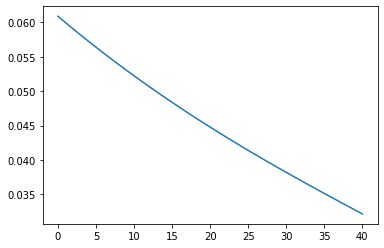

In [141]:
ϕ_low = ϕ
plt.plot(ϕ_low)

In [142]:
dmg_weight = np.array([0, 1])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - γbar)*(y_grid>γbar)

tol = 1e-8
ϵ = .3
lhs_error = 1

ϕ = - δ*η*y_grid
dy = y_grid[1] - y_grid[0]
ems = -δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    A = -δ*np.ones(y_grid.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid, ϕ,  ϵ, (False,0))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.0015507535227079368,	 ft error: 0.001361010462817653
episode: 2,	 ode error: 0.0013978609765297797,	 ft error: 0.0012967249911382112
episode: 3,	 ode error: 0.0013062282874470104,	 ft error: 0.001242129419445934
episode: 4,	 ode error: 0.0012441966481231525,	 ft error: 0.0011984244789036672
episode: 5,	 ode error: 0.0011979212134106058,	 ft error: 0.001162692407121767
episode: 6,	 ode error: 0.0011610972223622053,	 ft error: 0.001132622830512874
episode: 7,	 ode error: 0.0011304808203811256,	 ft error: 0.0011066402003871698
episode: 8,	 ode error: 0.001104221515169551,	 ft error: 0.0010837492122570068
episode: 9,	 ode error: 0.0010811765795622685,	 ft error: 0.001063255950214725
episode: 10,	 ode error: 0.0010605958677264548,	 ft error: 0.001044672398433012
episode: 11,	 ode error: 0.001041962643104836,	 ft error: 0.0010276472780169606
episode: 12,	 ode error: 0.0010249069132862744,	 ft error: 0.001011889179801186
episode: 13,	 ode error: 0.0010091554693913768

episode: 266,	 ode error: 0.00021378870405898594,	 ft error: 0.00021322578686013005
episode: 267,	 ode error: 0.00021259423148969545,	 ft error: 0.00021203453749616316
episode: 268,	 ode error: 0.00021140644143449066,	 ft error: 0.00021084995407536408
episode: 269,	 ode error: 0.00021022529780610375,	 ft error: 0.0002096720005518212
episode: 270,	 ode error: 0.00020905076464332697,	 ft error: 0.00020850064100769172
episode: 271,	 ode error: 0.0002078828061130067,	 ft error: 0.00020733583965519092
episode: 272,	 ode error: 0.00020672138651192066,	 ft error: 0.00020617756083839608
episode: 273,	 ode error: 0.00020556647026859969,	 ft error: 0.00020502576903500455
episode: 274,	 ode error: 0.00020441802194500445,	 ft error: 0.00020388042885792954
episode: 275,	 ode error: 0.0002032760062381933,	 ft error: 0.000202741505057058
episode: 276,	 ode error: 0.00020214038798183043,	 ft error: 0.00020160896252036098
episode: 277,	 ode error: 0.00020101113214770127,	 ft error: 0.000200482766275651

episode: 554,	 ode error: 4.3067277535761665e-05,	 ft error: 4.2439182092110506e-05
episode: 555,	 ode error: 4.283266326322074e-05,	 ft error: 4.21969267398505e-05
episode: 556,	 ode error: 4.259930465337852e-05,	 ft error: 4.195596402227035e-05
episode: 557,	 ode error: 4.23671951598416e-05,	 ft error: 4.171628720850418e-05
episode: 558,	 ode error: 4.2136328266118516e-05,	 ft error: 4.1477889598101614e-05
episode: 559,	 ode error: 4.190669748551756e-05,	 ft error: 4.1240764520935245e-05
episode: 560,	 ode error: 4.167829636102206e-05,	 ft error: 4.1004905337316266e-05
episode: 561,	 ode error: 4.1451118465152476e-05,	 ft error: 4.077030543755504e-05
episode: 562,	 ode error: 4.122515739985529e-05,	 ft error: 4.0536958242076704e-05
episode: 563,	 ode error: 4.100040679637265e-05,	 ft error: 4.03048572011668e-05
episode: 564,	 ode error: 4.077686031511696e-05,	 ft error: 4.0073995794901826e-05
episode: 565,	 ode error: 4.055451164554965e-05,	 ft error: 3.98443675330105e-05
episode: 56

episode: 854,	 ode error: 1.8446702255785837e-05,	 ft error: 1.646469111536477e-05
episode: 855,	 ode error: 1.8436842904375568e-05,	 ft error: 1.6422443677895082e-05
episode: 856,	 ode error: 1.8427077903947783e-05,	 ft error: 1.6380299354412653e-05
episode: 857,	 ode error: 1.8417406692970977e-05,	 ft error: 1.6338257905629726e-05
episode: 858,	 ode error: 1.8407828712812527e-05,	 ft error: 1.6296319092883038e-05
episode: 859,	 ode error: 1.8398343407728993e-05,	 ft error: 1.625448267819745e-05
episode: 860,	 ode error: 1.8388950224851536e-05,	 ft error: 1.6212748424193395e-05
episode: 861,	 ode error: 1.8379648614172146e-05,	 ft error: 1.6171116094202548e-05
episode: 862,	 ode error: 1.8370438028529547e-05,	 ft error: 1.6129585452140615e-05
episode: 863,	 ode error: 1.836131792359836e-05,	 ft error: 1.6088156262622964e-05
episode: 864,	 ode error: 1.8352287757872018e-05,	 ft error: 1.6046828290837423e-05
episode: 865,	 ode error: 1.8343346992655946e-05,	 ft error: 1.6005601302642586

episode: 1154,	 ode error: 1.79600045870622e-05,	 ft error: 7.515700938566054e-06
episode: 1155,	 ode error: 1.7962632881978542e-05,	 ft error: 7.495780172163865e-06
episode: 1156,	 ode error: 1.796527186710494e-05,	 ft error: 7.475910457528656e-06
episode: 1157,	 ode error: 1.7967921436399105e-05,	 ft error: 7.4560916705004865e-06
episode: 1158,	 ode error: 1.797058148444693e-05,	 ft error: 7.436323687162276e-06
episode: 1159,	 ode error: 1.7973251906464505e-05,	 ft error: 7.416606383874499e-06
episode: 1160,	 ode error: 1.797593259829437e-05,	 ft error: 7.396939637275187e-06
episode: 1161,	 ode error: 1.7978623456403674e-05,	 ft error: 7.377323324291493e-06
episode: 1162,	 ode error: 1.798132437787702e-05,	 ft error: 7.357757322093428e-06
episode: 1163,	 ode error: 1.79840352604163e-05,	 ft error: 7.338241508105433e-06
episode: 1164,	 ode error: 1.798675600233658e-05,	 ft error: 7.318775760098891e-06
episode: 1165,	 ode error: 1.7989486502562296e-05,	 ft error: 7.299359956064918e-06


episode: 1447,	 ode error: 1.8891595958426752e-05,	 ft error: 3.4220359469821124e-06
episode: 1448,	 ode error: 1.889468096015446e-05,	 ft error: 3.4127619559625364e-06
episode: 1449,	 ode error: 1.8897762748439474e-05,	 ft error: 3.4035124944648927e-06
episode: 1450,	 ode error: 1.8900841310739254e-05,	 ft error: 3.394287499773145e-06
episode: 1451,	 ode error: 1.8903916634633287e-05,	 ft error: 3.3850869094025535e-06
episode: 1452,	 ode error: 1.890698870782694e-05,	 ft error: 3.3759106609493328e-06
episode: 1453,	 ode error: 1.891005751814993e-05,	 ft error: 3.366758692229429e-06
episode: 1454,	 ode error: 1.891312305355179e-05,	 ft error: 3.3576309411513057e-06
episode: 1455,	 ode error: 1.891618530210662e-05,	 ft error: 3.3485273458200293e-06
episode: 1456,	 ode error: 1.891924425201049e-05,	 ft error: 3.33944784446788e-06
episode: 1457,	 ode error: 1.8922299891577655e-05,	 ft error: 3.3303923754774796e-06
episode: 1458,	 ode error: 1.8925352209242605e-05,	 ft error: 3.32136087737

episode: 1739,	 ode error: 1.9631347295103905e-05,	 ft error: 1.5386020656843469e-06
episode: 1740,	 ode error: 1.9633306486230783e-05,	 ft error: 1.534362006327487e-06
episode: 1741,	 ode error: 1.9635261937927455e-05,	 ft error: 1.5301334195759002e-06
episode: 1742,	 ode error: 1.9637213654030803e-05,	 ft error: 1.5259162752916575e-06
episode: 1743,	 ode error: 1.963916163838747e-05,	 ft error: 1.5217105431864868e-06
episode: 1744,	 ode error: 1.9641105894861494e-05,	 ft error: 1.5175161931687184e-06
episode: 1745,	 ode error: 1.9643046427331612e-05,	 ft error: 1.5133331951466822e-06
episode: 1746,	 ode error: 1.964498323968973e-05,	 ft error: 1.5091615192368755e-06
episode: 1747,	 ode error: 1.9646916335843583e-05,	 ft error: 1.5050011355095354e-06
episode: 1748,	 ode error: 1.964884571971587e-05,	 ft error: 1.500852014104289e-06
episode: 1749,	 ode error: 1.9650771395240507e-05,	 ft error: 1.4967141253226699e-06
episode: 1750,	 ode error: 1.9652693366369305e-05,	 ft error: 1.492587

episode: 2032,	 ode error: 2.0063891818916473e-05,	 ft error: 6.816904192634884e-07
episode: 2033,	 ode error: 2.00649494642573e-05,	 ft error: 6.797871943941177e-07
episode: 2034,	 ode error: 2.006600472432776e-05,	 ft error: 6.778892085284224e-07
episode: 2035,	 ode error: 2.0067057603632065e-05,	 ft error: 6.759964476151422e-07
episode: 2036,	 ode error: 2.0068108106667646e-05,	 ft error: 6.741088974526743e-07
episode: 2037,	 ode error: 2.0069156237929766e-05,	 ft error: 6.722265439550642e-07
episode: 2038,	 ode error: 2.007020200190773e-05,	 ft error: 6.703493731288757e-07
episode: 2039,	 ode error: 2.007124540308688e-05,	 ft error: 6.68477370969108e-07
episode: 2040,	 ode error: 2.00722864459479e-05,	 ft error: 6.666105234591954e-07
episode: 2041,	 ode error: 2.0073325134966485e-05,	 ft error: 6.647488166866555e-07
episode: 2042,	 ode error: 2.0074361474615022e-05,	 ft error: 6.628922367737008e-07
episode: 2043,	 ode error: 2.007539546936048e-05,	 ft error: 6.610407698656728e-07
e

episode: 2325,	 ode error: 2.0288884698287915e-05,	 ft error: 2.9917092628460135e-07
episode: 2326,	 ode error: 2.0289414381697733e-05,	 ft error: 2.983270187250272e-07
episode: 2327,	 ode error: 2.0289942770432843e-05,	 ft error: 2.974854652892933e-07
episode: 2328,	 ode error: 2.029046986739419e-05,	 ft error: 2.966462594779692e-07
episode: 2329,	 ode error: 2.0290995675475564e-05,	 ft error: 2.9580939489570746e-07
episode: 2330,	 ode error: 2.0291520197564955e-05,	 ft error: 2.9497486504307763e-07
episode: 2331,	 ode error: 2.0292043436546665e-05,	 ft error: 2.9414266355942686e-07
episode: 2332,	 ode error: 2.029256539529806e-05,	 ft error: 2.933127839684543e-07
episode: 2333,	 ode error: 2.029308607669146e-05,	 ft error: 2.924852199442015e-07
episode: 2334,	 ode error: 2.0293605483594906e-05,	 ft error: 2.9165996509132136e-07
episode: 2335,	 ode error: 2.0294123618869717e-05,	 ft error: 2.908370130491611e-07
episode: 2336,	 ode error: 2.0294640485371952e-05,	 ft error: 2.9001635750

episode: 2618,	 ode error: 2.0399207754755015e-05,	 ft error: 1.3029442359526375e-07
episode: 2619,	 ode error: 2.0399461524609537e-05,	 ft error: 1.2992383015506909e-07
episode: 2620,	 ode error: 2.0399714643602588e-05,	 ft error: 1.295542813884813e-07
episode: 2621,	 ode error: 2.0399967113318403e-05,	 ft error: 1.2918577438116494e-07
episode: 2622,	 ode error: 2.0400218935337153e-05,	 ft error: 1.2881830624191423e-07
episode: 2623,	 ode error: 2.04004701112357e-05,	 ft error: 1.2845187405639374e-07
episode: 2624,	 ode error: 2.040072064258793e-05,	 ft error: 1.2808647494496247e-07
episode: 2625,	 ode error: 2.0400970530963004e-05,	 ft error: 1.2772210603954431e-07
episode: 2626,	 ode error: 2.0401219777928194e-05,	 ft error: 1.2735876446049826e-07
episode: 2627,	 ode error: 2.0401468385046755e-05,	 ft error: 1.2699644732818335e-07
episode: 2628,	 ode error: 2.0401716353877282e-05,	 ft error: 1.2663515182078275e-07
episode: 2629,	 ode error: 2.0401963685976962e-05,	 ft error: 1.26274

episode: 2912,	 ode error: 2.0451458203717208e-05,	 ft error: 5.623019514131948e-08
episode: 2913,	 ode error: 2.0451575935622216e-05,	 ft error: 5.6069172510904895e-08
episode: 2914,	 ode error: 2.0451693355700814e-05,	 ft error: 5.590860763932115e-08
episode: 2915,	 ode error: 2.0451810464748804e-05,	 ft error: 5.5748499231308056e-08
episode: 2916,	 ode error: 2.0451927263564216e-05,	 ft error: 5.558884600317023e-08
episode: 2917,	 ode error: 2.04520437529396e-05,	 ft error: 5.542964667121231e-08
episode: 2918,	 ode error: 2.0452159933666476e-05,	 ft error: 5.527089994017409e-08
episode: 2919,	 ode error: 2.0452275806535447e-05,	 ft error: 5.51126045726195e-08
episode: 2920,	 ode error: 2.0452391372334565e-05,	 ft error: 5.495475928485316e-08
episode: 2921,	 ode error: 2.0452506631848737e-05,	 ft error: 5.4797362781614886e-08
episode: 2922,	 ode error: 2.0452621585863578e-05,	 ft error: 5.464041381390376e-08
episode: 2923,	 ode error: 2.0452736235159982e-05,	 ft error: 5.448391113271

episode: 3206,	 ode error: 2.0475464136096577e-05,	 ft error: 2.4140774726455483e-08
episode: 3207,	 ode error: 2.047551761278721e-05,	 ft error: 2.4071255833498416e-08
episode: 3208,	 ode error: 2.0475570944563596e-05,	 ft error: 2.4001935901759218e-08
episode: 3209,	 ode error: 2.0475624131807864e-05,	 ft error: 2.3932814433950494e-08
episode: 3210,	 ode error: 2.0475677174902466e-05,	 ft error: 2.3863890805571795e-08
episode: 3211,	 ode error: 2.047573007422866e-05,	 ft error: 2.379516448464125e-08
episode: 3212,	 ode error: 2.0475782830166084e-05,	 ft error: 2.3726634916047356e-08
episode: 3213,	 ode error: 2.0475835443094638e-05,	 ft error: 2.3658301509984124e-08
episode: 3214,	 ode error: 2.0475887913392818e-05,	 ft error: 2.3590163734469687e-08
episode: 3215,	 ode error: 2.0475940241437168e-05,	 ft error: 2.3522221022827715e-08
episode: 3216,	 ode error: 2.0475992427603743e-05,	 ft error: 2.345447281994669e-08
episode: 3217,	 ode error: 2.047604447226914e-05,	 ft error: 2.338691

episode: 3500,	 ode error: 2.0486290318658226e-05,	 ft error: 1.0319116683828641e-08
episode: 3501,	 ode error: 2.0486314229738536e-05,	 ft error: 1.028926095945441e-08
episode: 3502,	 ode error: 2.048633807491242e-05,	 ft error: 1.0259491173281177e-08
episode: 3503,	 ode error: 2.0486361854357574e-05,	 ft error: 1.0229807082447659e-08
episode: 3504,	 ode error: 2.0486385568252896e-05,	 ft error: 1.0200208444092567e-08
episode: 3505,	 ode error: 2.0486409216774893e-05,	 ft error: 1.0170695050049083e-08
episode: 3506,	 ode error: 2.0486432800100236e-05,	 ft error: 1.0141266588066985e-08
episode: 3507,	 ode error: 2.0486456318406462e-05,	 ft error: 1.01119228731091e-08
episode: 3508,	 ode error: 2.0486479771869863e-05,	 ft error: 1.0082663616054848e-08
episode: 3509,	 ode error: 2.0486503160665158e-05,	 ft error: 1.0053488608737412e-08
episode: 3510,	 ode error: 2.0486526484967066e-05,	 ft error: 1.0024397596730683e-08
episode: 3511,	 ode error: 2.0486549744951608e-05,	 ft error: 9.99539

In [143]:
ϕ_high = ϕ

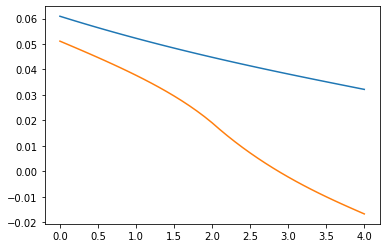

In [171]:
plt.plot(y_grid, ϕ_low)
plt.plot(y_grid, ϕ_high)
# plt.plot(y_grid, v_dict[2])

In [172]:
bd = (ϕ_low[numy_bar]+ϕ_high[numy_bar])/2
bd

0.031917725705683526

In [175]:
dmg_weight = np.array([0.5, 0.5])
y_grid_cap = np.linspace(0,2,100)
dΛ = γ1 + γ2*y_grid_cap + np.average(γ2p, weights=dmg_weight)*(y_grid_cap - γbar)*(y_grid_cap>γbar)

tol = 1e-8
ϵ = .3
lhs_error = 1

ϕ = - δ*η*y_grid_cap
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    ems[ems<=0] = 1e-15
    A = -δ*np.ones(y_grid_cap.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid_cap.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ,  ϵ, (True,bd))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.0015507702251111315,	 ft error: 0.10852575235227867
episode: 2,	 ode error: 0.011371585703428224,	 ft error: 0.011126841591580491
episode: 3,	 ode error: 0.011371585703428258,	 ft error: 0.011093564057119936
episode: 4,	 ode error: 0.011371585703428357,	 ft error: 0.011060380517461839
episode: 5,	 ode error: 0.011371585703428356,	 ft error: 0.011027296488493765
episode: 6,	 ode error: 0.011371585703428302,	 ft error: 0.010994312365516474
episode: 7,	 ode error: 0.01137158570342969,	 ft error: 0.04393403224019229
episode: 8,	 ode error: 0.011371585703436436,	 ft error: 0.011092831078270571
episode: 9,	 ode error: 0.011371585703433355,	 ft error: 0.011059659282180192
episode: 10,	 ode error: 0.011371585703430139,	 ft error: 0.011026580910132098
episode: 11,	 ode error: 0.011371585703445137,	 ft error: 0.010993616441131586
episode: 12,	 ode error: 0.011371585703429716,	 ft error: 0.010960717721470205
episode: 13,	 ode error: 0.011371585703428848,	 ft error: 0.012

episode: 195,	 ode error: 0.01137158570342761,	 ft error: 0.011046781471531859
episode: 196,	 ode error: 0.011371585703468426,	 ft error: 0.011013734153404002
episode: 197,	 ode error: 0.011371585703491756,	 ft error: 0.004859387524326684
episode: 198,	 ode error: 0.011371585703969195,	 ft error: 0.011573724840737055
episode: 199,	 ode error: 0.011371585703430026,	 ft error: 0.01102994679682537
episode: 200,	 ode error: 0.011371585703784343,	 ft error: 0.01108654895093616
episode: 201,	 ode error: 0.011371585703421519,	 ft error: 0.011030116339216878
episode: 202,	 ode error: 0.011371585703501505,	 ft error: 0.00928298314797255
episode: 203,	 ode error: 0.011371585703403722,	 ft error: 0.01102488904486115
episode: 204,	 ode error: 0.011371585703427214,	 ft error: 0.006050787567554569
episode: 205,	 ode error: 0.01137158570342217,	 ft error: 0.0626269991805393
episode: 206,	 ode error: 0.011371585703428205,	 ft error: 0.01119733547562297
episode: 207,	 ode error: 0.01137158570342584,	 f

episode: 406,	 ode error: 0.011371585703437206,	 ft error: 0.011046743545402329
episode: 407,	 ode error: 0.011371585703673718,	 ft error: 0.011013724612171396
episode: 408,	 ode error: 0.011371585703428142,	 ft error: 0.0036698531431735683
episode: 409,	 ode error: 0.011371585703428154,	 ft error: 0.005706124118264224
episode: 410,	 ode error: 0.01137158570321157,	 ft error: 0.02816034684603563
episode: 411,	 ode error: 0.011371585703428305,	 ft error: 0.011093032447546005
episode: 412,	 ode error: 0.011371585703425661,	 ft error: 0.011059853026520693
episode: 413,	 ode error: 0.011371585703416157,	 ft error: 0.011026770493875423
episode: 414,	 ode error: 0.01137158570376695,	 ft error: 0.019947949265238196
episode: 415,	 ode error: 0.011371585703400078,	 ft error: 0.011053456017882386
episode: 416,	 ode error: 0.011371585703430189,	 ft error: 0.011020393823431252
episode: 417,	 ode error: 0.011371585703456623,	 ft error: 0.007318083869650895
episode: 418,	 ode error: 0.01137158570343

episode: 622,	 ode error: 0.011371585703419892,	 ft error: 0.011028862270937917
episode: 623,	 ode error: 0.011371585703406024,	 ft error: 0.0036849360647213756
episode: 624,	 ode error: 0.011371585703450817,	 ft error: 0.005850770280013036
episode: 625,	 ode error: 0.011371585703429509,	 ft error: 0.04963068794438934
episode: 626,	 ode error: 0.011371585703428184,	 ft error: 0.029566268822369315
episode: 627,	 ode error: 0.011371585703428255,	 ft error: 0.011139420435697055
episode: 628,	 ode error: 0.011371585703543645,	 ft error: 0.011106087634605915
episode: 629,	 ode error: 0.011371585703468776,	 ft error: 0.011072881557804542
episode: 630,	 ode error: 0.011371585703376609,	 ft error: 0.011039766926423502
episode: 631,	 ode error: 0.01137158570338331,	 ft error: 0.005509930825964982
episode: 632,	 ode error: 0.011371585703429877,	 ft error: 0.023879879182381405
episode: 633,	 ode error: 0.011371585703366615,	 ft error: 0.011094639179455412
episode: 634,	 ode error: 0.0113715857034

episode: 840,	 ode error: 0.011371585703491807,	 ft error: 0.0060682238124750805
episode: 841,	 ode error: 0.011371585703421923,	 ft error: 0.046091887057042126
episode: 842,	 ode error: 0.011371585703428229,	 ft error: 0.01935229837806303
episode: 843,	 ode error: 0.011371585703589735,	 ft error: 0.011100667186879812
episode: 844,	 ode error: 0.011371585703427257,	 ft error: 0.011067477239291143
episode: 845,	 ode error: 0.0113715857035372,	 ft error: 0.011034380113651137
episode: 846,	 ode error: 0.011371585703480324,	 ft error: 0.07250238581742653
episode: 847,	 ode error: 0.011371585703428042,	 ft error: 0.011218228409891746
episode: 848,	 ode error: 0.011371585703428421,	 ft error: 0.011184672652112936
episode: 849,	 ode error: 0.011371585703428522,	 ft error: 0.01115121846808531
episode: 850,	 ode error: 0.0113715857034286,	 ft error: 0.011117864573790121
episode: 851,	 ode error: 0.011371585703428826,	 ft error: 0.011084610640480006
episode: 852,	 ode error: 0.01137158570349789,

episode: 1053,	 ode error: 0.011371585703449793,	 ft error: 0.010215540254606543
episode: 1054,	 ode error: 0.011371585703563794,	 ft error: 0.011010637258079894
episode: 1055,	 ode error: 0.011371585703498697,	 ft error: 0.007415512986702798
episode: 1056,	 ode error: 0.011371585703480026,	 ft error: 0.010999869684596477
episode: 1057,	 ode error: 0.011371585703449176,	 ft error: 0.004472932627026652
episode: 1058,	 ode error: 0.01137158570354026,	 ft error: 0.008528196371476435
episode: 1059,	 ode error: 0.011371585703481612,	 ft error: 0.011005854557596517
episode: 1060,	 ode error: 0.01137158570345759,	 ft error: 0.005349971531821383
episode: 1061,	 ode error: 0.011371585703601585,	 ft error: 0.016097194783304573
episode: 1062,	 ode error: 0.011371585703514491,	 ft error: 0.011037077588170935
episode: 1063,	 ode error: 0.011371585703427455,	 ft error: 0.011004060650792296
episode: 1064,	 ode error: 0.011371585703448546,	 ft error: 0.004243273584239378
episode: 1065,	 ode error: 0.0

episode: 1272,	 ode error: 0.011371585703443883,	 ft error: 0.011034416870429824
episode: 1273,	 ode error: 0.01137158570342541,	 ft error: 0.01100141210374141
episode: 1274,	 ode error: 0.011371585703419437,	 ft error: 0.0052162876817670135
episode: 1275,	 ode error: 0.011371585703450945,	 ft error: 0.014546384968346987
episode: 1276,	 ode error: 0.011371585703435721,	 ft error: 0.011027617518811296
episode: 1277,	 ode error: 0.011371585703392195,	 ft error: 0.010994626352903394
episode: 1278,	 ode error: 0.011371585703428291,	 ft error: 0.003763512216169906
episode: 1279,	 ode error: 0.011371585703403632,	 ft error: 0.005768003420040285
episode: 1280,	 ode error: 0.011371585703336176,	 ft error: 0.026847669372984686
episode: 1281,	 ode error: 0.011371585703440665,	 ft error: 0.011070556908025749
episode: 1282,	 ode error: 0.011371585703468938,	 ft error: 0.011037448238170773
episode: 1283,	 ode error: 0.011371585703472646,	 ft error: 0.09848166918697168
episode: 1284,	 ode error: 0.0

episode: 1490,	 ode error: 0.011371585703428125,	 ft error: 0.01107043450684985
episode: 1491,	 ode error: 0.011371585703500088,	 ft error: 0.011037326390536735
episode: 1492,	 ode error: 0.011371585703434915,	 ft error: 0.011004316837141892
episode: 1493,	 ode error: 0.011371585703376689,	 ft error: 0.004078396895620368
episode: 1494,	 ode error: 0.01137158570341516,	 ft error: 0.006903677061139722
episode: 1495,	 ode error: 0.011371585703420391,	 ft error: 0.011004248820211612
episode: 1496,	 ode error: 0.011371585703370555,	 ft error: 0.004083136131345617
episode: 1497,	 ode error: 0.011371585703405327,	 ft error: 0.006921095875746155
episode: 1498,	 ode error: 0.011371585703407445,	 ft error: 0.011004247066227057
episode: 1499,	 ode error: 0.011371585703370811,	 ft error: 0.004094131701140451
episode: 1500,	 ode error: 0.011371585703400787,	 ft error: 0.006962207334951509
episode: 1501,	 ode error: 0.011371585703395318,	 ft error: 0.011004400990149172
episode: 1502,	 ode error: 0.0

episode: 1708,	 ode error: 0.011371585703428253,	 ft error: 0.011193407632031112
episode: 1709,	 ode error: 0.01137158570342815,	 ft error: 0.011159928336556501
episode: 1710,	 ode error: 0.011371585703418856,	 ft error: 0.011126551919714943
episode: 1711,	 ode error: 0.011371585703428243,	 ft error: 0.01109326820336591
episode: 1712,	 ode error: 0.011371585703442925,	 ft error: 0.01106008755908827
episode: 1713,	 ode error: 0.011371585703515617,	 ft error: 0.011027013855922732
episode: 1714,	 ode error: 0.011371585703509029,	 ft error: 0.006663892360717733
episode: 1715,	 ode error: 0.01137158570342802,	 ft error: 0.01101395626193417
episode: 1716,	 ode error: 0.011371585703473085,	 ft error: 0.003965041269762218
episode: 1717,	 ode error: 0.011371585703489836,	 ft error: 0.006662022516982968
episode: 1718,	 ode error: 0.011371585703473474,	 ft error: 0.0110128065116
episode: 1719,	 ode error: 0.011371585703484796,	 ft error: 0.003908564021958204
episode: 1720,	 ode error: 0.011371585

episode: 1926,	 ode error: 0.011371585703430671,	 ft error: 0.011019971240603967
episode: 1927,	 ode error: 0.01137158570345088,	 ft error: 0.010987020951731048
episode: 1928,	 ode error: 0.011371585703439163,	 ft error: 0.0046334157526885505
episode: 1929,	 ode error: 0.011371585703428248,	 ft error: 0.009075110305885372
episode: 1930,	 ode error: 0.011371585703453585,	 ft error: 0.010995160102835234
episode: 1931,	 ode error: 0.011371585703452826,	 ft error: 0.005983183317773766
episode: 1932,	 ode error: 0.011371585703361446,	 ft error: 0.030892294866855935
episode: 1933,	 ode error: 0.011371585703428557,	 ft error: 0.011072558630780181
episode: 1934,	 ode error: 0.01137158570346172,	 ft error: 0.011039443223466389
episode: 1935,	 ode error: 0.011371585703469519,	 ft error: 0.011006435701580535
episode: 1936,	 ode error: 0.011371585703432913,	 ft error: 0.01097350479256146
episode: 1937,	 ode error: 0.011371585703423467,	 ft error: 0.004174480819752787
episode: 1938,	 ode error: 0.0

episode: 2143,	 ode error: 0.011371585703436866,	 ft error: 0.011007863193140243
episode: 2144,	 ode error: 0.011371585703428253,	 ft error: 0.0057720865091910505
episode: 2145,	 ode error: 0.011371585703429636,	 ft error: 0.024712193602030506
episode: 2146,	 ode error: 0.011371585703476487,	 ft error: 0.01106610520618886
episode: 2147,	 ode error: 0.011371585703456057,	 ft error: 0.011033011290593912
episode: 2148,	 ode error: 0.011371585703446423,	 ft error: 0.011000011992166011
episode: 2149,	 ode error: 0.011371585703400092,	 ft error: 0.015065321953787583
episode: 2150,	 ode error: 0.011371585703445179,	 ft error: 0.011012171008743191
episode: 2151,	 ode error: 0.011371585703426735,	 ft error: 0.010979232112983796
episode: 2152,	 ode error: 0.011371585703418367,	 ft error: 0.004197679825763409
episode: 2153,	 ode error: 0.011371585703422006,	 ft error: 0.0070459578156486374
episode: 2154,	 ode error: 0.011371585703421982,	 ft error: 0.010980020939166949
episode: 2155,	 ode error: 

episode: 2361,	 ode error: 0.011371585703438778,	 ft error: 0.03698049499563087
episode: 2362,	 ode error: 0.011371585703451328,	 ft error: 0.011077147279633267
episode: 2363,	 ode error: 0.01137158570344404,	 ft error: 0.011044019137696098
episode: 2364,	 ode error: 0.011371585703444462,	 ft error: 0.011010988608493274
episode: 2365,	 ode error: 0.011371585703434689,	 ft error: 0.010978053955341585
episode: 2366,	 ode error: 0.011371585703348758,	 ft error: 0.01299918477365366
episode: 2367,	 ode error: 0.011371585703433856,	 ft error: 0.010984098571961308
episode: 2368,	 ode error: 0.011371585703428616,	 ft error: 0.019766598034162062
episode: 2369,	 ode error: 0.011371585703444965,	 ft error: 0.011010368106595727
episode: 2370,	 ode error: 0.011371585703477705,	 ft error: 0.010977451175191352
episode: 2371,	 ode error: 0.011371585703446532,	 ft error: 0.007078070319327338
episode: 2372,	 ode error: 0.011371585703455233,	 ft error: 0.010965782207940263
episode: 2373,	 ode error: 0.01

episode: 2578,	 ode error: 0.011371585703476909,	 ft error: 0.010992766997454972
episode: 2579,	 ode error: 0.011371585703454652,	 ft error: 0.005228911813715184
episode: 2580,	 ode error: 0.01137158570342841,	 ft error: 0.013717417230954881
episode: 2581,	 ode error: 0.011371585703526461,	 ft error: 0.011016557385162216
episode: 2582,	 ode error: 0.01137158570342951,	 ft error: 0.021932278194028394
episode: 2583,	 ode error: 0.011371585703438547,	 ft error: 0.011049194943383918
episode: 2584,	 ode error: 0.011371585703493208,	 ft error: 0.01101615556789246
episode: 2585,	 ode error: 0.011371585703452543,	 ft error: 0.010983202969239419
episode: 2586,	 ode error: 0.011371585703428097,	 ft error: 0.004147759835092727
episode: 2587,	 ode error: 0.011371585703432038,	 ft error: 0.006899956238008573
episode: 2588,	 ode error: 0.011371585703441765,	 ft error: 0.0109833935897419
episode: 2589,	 ode error: 0.011371585703428519,	 ft error: 0.004187084074309764
episode: 2590,	 ode error: 0.0113

episode: 2790,	 ode error: 0.011371585703427924,	 ft error: 0.03432294239295628
episode: 2791,	 ode error: 0.011371585703411534,	 ft error: 0.011083880038373132
episode: 2792,	 ode error: 0.011371585703428385,	 ft error: 0.011050729305081575
episode: 2793,	 ode error: 0.011371585703560628,	 ft error: 0.01101769611193626
episode: 2794,	 ode error: 0.01137158570352482,	 ft error: 0.009757022195170089
episode: 2795,	 ode error: 0.011371585703482094,	 ft error: 0.011013912159633132
episode: 2796,	 ode error: 0.01137158570345986,	 ft error: 0.006592065338779777
episode: 2797,	 ode error: 0.011371585703475458,	 ft error: 0.011000687864646676
episode: 2798,	 ode error: 0.01137158570342819,	 ft error: 0.003967709626941076
episode: 2799,	 ode error: 0.011371585703478945,	 ft error: 0.006523036019657393
episode: 2800,	 ode error: 0.011371585703464528,	 ft error: 0.01099915875834083
episode: 2801,	 ode error: 0.011371585703428213,	 ft error: 0.003884323047315316
episode: 2802,	 ode error: 0.01137

episode: 3009,	 ode error: 0.011371585703458892,	 ft error: 0.012336758747081206
episode: 3010,	 ode error: 0.011371585703257076,	 ft error: 0.011031188569092363
episode: 3011,	 ode error: 0.011371585703340919,	 ft error: 0.01277396334163633
episode: 3012,	 ode error: 0.011371585703578055,	 ft error: 0.011036419287925113
episode: 3013,	 ode error: 0.011371585702798953,	 ft error: 0.013637810175958644
episode: 3014,	 ode error: 0.01137158570552758,	 ft error: 0.011044204058467923
episode: 3015,	 ode error: 0.011371585703626846,	 ft error: 0.020819340129964004
episode: 3016,	 ode error: 0.011371585703410042,	 ft error: 0.011073433458030215
episode: 3017,	 ode error: 0.011371585703396102,	 ft error: 0.011040310333257638
episode: 3018,	 ode error: 0.011371585703429913,	 ft error: 0.011007288819751921
episode: 3019,	 ode error: 0.01137158570344017,	 ft error: 0.004652068085484041
episode: 3020,	 ode error: 0.011371585703459228,	 ft error: 0.0097788914950812
episode: 3021,	 ode error: 0.0113

episode: 3227,	 ode error: 0.011371585703431072,	 ft error: 0.01157211827448202
episode: 3228,	 ode error: 0.011371585703543644,	 ft error: 0.01103219759468539
episode: 3229,	 ode error: 0.011371585703609124,	 ft error: 0.009446782366929569
episode: 3230,	 ode error: 0.0113715857034321,	 ft error: 0.011027455074897571
episode: 3231,	 ode error: 0.011371585703429372,	 ft error: 0.006287436453633609
episode: 3232,	 ode error: 0.011371585703429138,	 ft error: 0.011013276109245938
episode: 3233,	 ode error: 0.011371585703428711,	 ft error: 0.0037960459760985844
episode: 3234,	 ode error: 0.011371585703428957,	 ft error: 0.006108105524939113
episode: 3235,	 ode error: 0.011371585703399004,	 ft error: 0.0661427158296538
episode: 3236,	 ode error: 0.01137158570342825,	 ft error: 0.011207792335577456
episode: 3237,	 ode error: 0.011371585703428963,	 ft error: 0.011174268519961983
episode: 3238,	 ode error: 0.011371585703429487,	 ft error: 0.011140845376167986
episode: 3239,	 ode error: 0.01137

episode: 3443,	 ode error: 0.011371585703353828,	 ft error: 0.013864194862204152
episode: 3444,	 ode error: 0.011371585703614967,	 ft error: 0.011032781617234184
episode: 3445,	 ode error: 0.011371585703382843,	 ft error: 0.0220074542723243
episode: 3446,	 ode error: 0.011371585703428234,	 ft error: 0.0110655983579348
episode: 3447,	 ode error: 0.011371585703428276,	 ft error: 0.011032501033743784
episode: 3448,	 ode error: 0.011371585703422964,	 ft error: 0.010999499173814964
episode: 3449,	 ode error: 0.011371585703449124,	 ft error: 0.007466092002599219
episode: 3450,	 ode error: 0.011371585703431074,	 ft error: 0.010988931769700729
episode: 3451,	 ode error: 0.011371585703434958,	 ft error: 0.004630740734903327
episode: 3452,	 ode error: 0.011371585703458954,	 ft error: 0.009222294402245257
episode: 3453,	 ode error: 0.011371585703427327,	 ft error: 0.010997498770170004
episode: 3454,	 ode error: 0.011371585703436061,	 ft error: 0.006380176291564152
episode: 3455,	 ode error: 0.011

episode: 3661,	 ode error: 0.011371585703436434,	 ft error: 0.00888543636815599
episode: 3662,	 ode error: 0.011371585703365017,	 ft error: 0.010993987748700265
episode: 3663,	 ode error: 0.011371585703454638,	 ft error: 0.005831790466844693
episode: 3664,	 ode error: 0.01137158570342849,	 ft error: 0.025539047265671543
episode: 3665,	 ode error: 0.011371585703468187,	 ft error: 0.011054957063891117
episode: 3666,	 ode error: 0.011371585703617551,	 ft error: 0.011021904038152175
episode: 3667,	 ode error: 0.011371585703380885,	 ft error: 0.02024763283647974
episode: 3668,	 ode error: 0.011371585703514993,	 ft error: 0.011049487396185569
episode: 3669,	 ode error: 0.011371585703428255,	 ft error: 0.011016436818602992
episode: 3670,	 ode error: 0.011371585703430297,	 ft error: 0.010983487431354822
episode: 3671,	 ode error: 0.011371585703431893,	 ft error: 0.0053534515746804425
episode: 3672,	 ode error: 0.01137158570343475,	 ft error: 0.015142270887695784
episode: 3673,	 ode error: 0.01

episode: 3878,	 ode error: 0.011371585703428255,	 ft error: 0.01125662031877654
episode: 3879,	 ode error: 0.011371585703428244,	 ft error: 0.011222950640639742
episode: 3880,	 ode error: 0.011371585703422445,	 ft error: 0.01118938869562751
episode: 3881,	 ode error: 0.011371585703445583,	 ft error: 0.011155918167795367
episode: 3882,	 ode error: 0.011371585703429532,	 ft error: 0.011122546713614269
episode: 3883,	 ode error: 0.011371585703432243,	 ft error: 0.011089278465441998
episode: 3884,	 ode error: 0.011371585703435473,	 ft error: 0.011056110299584561
episode: 3885,	 ode error: 0.011371585703434307,	 ft error: 0.011023041917800392
episode: 3886,	 ode error: 0.011371585703423785,	 ft error: 0.010990067682607088
episode: 3887,	 ode error: 0.01137158570342468,	 ft error: 0.008313138155643093
episode: 3888,	 ode error: 0.011371585703428243,	 ft error: 0.010982064174421562
episode: 3889,	 ode error: 0.011371585703488936,	 ft error: 0.005378764931679468
episode: 3890,	 ode error: 0.01

episode: 4096,	 ode error: 0.01137158570338168,	 ft error: 0.01122318199761627
episode: 4097,	 ode error: 0.011371585703457372,	 ft error: 0.011189576980375194
episode: 4098,	 ode error: 0.011371585703428243,	 ft error: 0.011156099884232374
episode: 4099,	 ode error: 0.01137158570342825,	 ft error: 0.011122731537343703
episode: 4100,	 ode error: 0.011371585703428477,	 ft error: 0.011089463107279804
episode: 4101,	 ode error: 0.011371585703428243,	 ft error: 0.011056294007026029
episode: 4102,	 ode error: 0.011371585703508318,	 ft error: 0.011023235898578138
episode: 4103,	 ode error: 0.011371585703431825,	 ft error: 0.01099025396189928
episode: 4104,	 ode error: 0.011371585703438493,	 ft error: 0.006450209496275181
episode: 4105,	 ode error: 0.01137158570343122,	 ft error: 0.010976675655030002
episode: 4106,	 ode error: 0.011371585703432052,	 ft error: 0.003920964218846005
episode: 4107,	 ode error: 0.011371585703434791,	 ft error: 0.006087151268714704
episode: 4108,	 ode error: 0.0113

episode: 4315,	 ode error: 0.011371585703428272,	 ft error: 0.01104612432342152
episode: 4316,	 ode error: 0.011371585703471496,	 ft error: 0.011013093033804993
episode: 4317,	 ode error: 0.011371585703428349,	 ft error: 0.011451032329275104
episode: 4318,	 ode error: 0.01137158570339414,	 ft error: 0.01101440549515698
episode: 4319,	 ode error: 0.011371585703424843,	 ft error: 0.009359456270010613
episode: 4320,	 ode error: 0.011371585702883692,	 ft error: 0.011009454363281174
episode: 4321,	 ode error: 0.011371585703429265,	 ft error: 0.00688163809239938
episode: 4322,	 ode error: 0.011371585703428794,	 ft error: 0.010997099563680451
episode: 4323,	 ode error: 0.01137158570342858,	 ft error: 0.004231505826736591
episode: 4324,	 ode error: 0.011371585703428931,	 ft error: 0.007462030200488499
episode: 4325,	 ode error: 0.011371585703428574,	 ft error: 0.01099918237947514
episode: 4326,	 ode error: 0.011371585703428456,	 ft error: 0.0045309174674885554
episode: 4327,	 ode error: 0.0113

episode: 4532,	 ode error: 0.011371585703451944,	 ft error: 0.01104853215827376
episode: 4533,	 ode error: 0.0113715857034365,	 ft error: 0.011015487339627969
episode: 4534,	 ode error: 0.011371585703415425,	 ft error: 0.011925295598444104
episode: 4535,	 ode error: 0.011371585703433927,	 ft error: 0.011018208106447333
episode: 4536,	 ode error: 0.011371585703424324,	 ft error: 0.012765963566782725
episode: 4537,	 ode error: 0.011371585703432894,	 ft error: 0.011023435229856143
episode: 4538,	 ode error: 0.01137158570346893,	 ft error: 0.0173508077959209
episode: 4539,	 ode error: 0.011371585703446126,	 ft error: 0.011042360585938197
episode: 4540,	 ode error: 0.011371585703518025,	 ft error: 0.011009343454493812
episode: 4541,	 ode error: 0.011371585703437973,	 ft error: 0.004758175666639362
episode: 4542,	 ode error: 0.011371585703366757,	 ft error: 0.010422044853337075
episode: 4543,	 ode error: 0.011371585703514701,	 ft error: 0.011021815013925544
episode: 4544,	 ode error: 0.01137

episode: 4751,	 ode error: 0.011371585703384575,	 ft error: 0.011035194605220717
episode: 4752,	 ode error: 0.011371585703441994,	 ft error: 0.011002193730787153
episode: 4753,	 ode error: 0.011371585703437596,	 ft error: 0.004772741544770085
episode: 4754,	 ode error: 0.011371585703454696,	 ft error: 0.010337229316170326
episode: 4755,	 ode error: 0.011371585703427405,	 ft error: 0.011014476928136957
episode: 4756,	 ode error: 0.011371585703472808,	 ft error: 0.007624051689419839
episode: 4757,	 ode error: 0.01137158570348722,	 ft error: 0.011004352251720141
episode: 4758,	 ode error: 0.011371585703441642,	 ft error: 0.00460256603264762
episode: 4759,	 ode error: 0.011371585703427166,	 ft error: 0.00930554774569268
episode: 4760,	 ode error: 0.011371585703478815,	 ft error: 0.011013031917553479
episode: 4761,	 ode error: 0.011371585703451936,	 ft error: 0.006103991313684384
episode: 4762,	 ode error: 0.011371585703429898,	 ft error: 0.05047406593519068
episode: 4763,	 ode error: 0.011

episode: 4969,	 ode error: 0.011371585703439529,	 ft error: 0.011118184760276508
episode: 4970,	 ode error: 0.011371585703476537,	 ft error: 0.011084925458765231
episode: 4971,	 ode error: 0.011371585703663839,	 ft error: 0.011051771717083544
episode: 4972,	 ode error: 0.011371585703419194,	 ft error: 0.011018712498726527
episode: 4973,	 ode error: 0.011371585703427552,	 ft error: 0.010985755978954665
episode: 4974,	 ode error: 0.011371585703461376,	 ft error: 0.011117037717653815
episode: 4975,	 ode error: 0.011371585703429417,	 ft error: 0.01098614960234182
episode: 4976,	 ode error: 0.011371585703461931,	 ft error: 0.010581261375881093
episode: 4977,	 ode error: 0.011371585703429457,	 ft error: 0.010984938727210061
episode: 4978,	 ode error: 0.01137158570345424,	 ft error: 0.008977042730052556
episode: 4979,	 ode error: 0.011371585703428968,	 ft error: 0.010978932963826795
episode: 4980,	 ode error: 0.011371585703438358,	 ft error: 0.006207430557785551
episode: 4981,	 ode error: 0.0

episode: 5188,	 ode error: 0.011371585703378498,	 ft error: 0.010979884359222442
episode: 5189,	 ode error: 0.011371585703427676,	 ft error: 0.007308643503988821
episode: 5190,	 ode error: 0.011371585703368383,	 ft error: 0.010968877888035744
episode: 5191,	 ode error: 0.011371585703427329,	 ft error: 0.004674219210353247
episode: 5192,	 ode error: 0.01137158570342831,	 ft error: 0.00897210274618431
episode: 5193,	 ode error: 0.011371585703414505,	 ft error: 0.010976881789855194
episode: 5194,	 ode error: 0.011371585703428385,	 ft error: 0.005969565207997107
episode: 5195,	 ode error: 0.01137158570342844,	 ft error: 0.0246877573156859
episode: 5196,	 ode error: 0.01137158570343254,	 ft error: 0.011035735234691296
episode: 5197,	 ode error: 0.01137158570346763,	 ft error: 0.011002735557131662
episode: 5198,	 ode error: 0.01137158570344113,	 ft error: 0.010969822694737
episode: 5199,	 ode error: 0.01137158570332502,	 ft error: 0.00629135815478878
episode: 5200,	 ode error: 0.011371585703

episode: 5405,	 ode error: 0.01137158570347474,	 ft error: 0.011263191128459093
episode: 5406,	 ode error: 0.011371585703428387,	 ft error: 0.01122954530752034
episode: 5407,	 ode error: 0.011371585703428748,	 ft error: 0.011195955244989477
episode: 5408,	 ode error: 0.011371585703428251,	 ft error: 0.016192558529947793
episode: 5409,	 ode error: 0.011371585703428465,	 ft error: 0.011129079800403395
episode: 5410,	 ode error: 0.01137158570344002,	 ft error: 0.011095787885203018
episode: 5411,	 ode error: 0.011371585703428692,	 ft error: 0.011062604552714883
episode: 5412,	 ode error: 0.011371585703461423,	 ft error: 0.011029519606762477
episode: 5413,	 ode error: 0.011371585703354519,	 ft error: 0.010996521086168012
episode: 5414,	 ode error: 0.011371585703357232,	 ft error: 0.004836705508625405
episode: 5415,	 ode error: 0.011371585703394724,	 ft error: 0.010590300101373507
episode: 5416,	 ode error: 0.011371585703378354,	 ft error: 0.011009772932668496
episode: 5417,	 ode error: 0.01

episode: 5621,	 ode error: 0.011371585703438691,	 ft error: 0.011006355246049222
episode: 5622,	 ode error: 0.011371585703449176,	 ft error: 0.00512155564161628
episode: 5623,	 ode error: 0.011371585703490108,	 ft error: 0.01344637536425626
episode: 5624,	 ode error: 0.011371585703399587,	 ft error: 0.011028968269867658
episode: 5625,	 ode error: 0.01137158570373406,	 ft error: 0.02071969681412061
episode: 5626,	 ode error: 0.011371585703428494,	 ft error: 0.011057956877465294
episode: 5627,	 ode error: 0.011371585703487428,	 ft error: 0.011024889667607889
episode: 5628,	 ode error: 0.011371585703425613,	 ft error: 0.010991904680486617
episode: 5629,	 ode error: 0.011371585703434271,	 ft error: 0.005867168108007869
episode: 5630,	 ode error: 0.011371585703427847,	 ft error: 0.029804907112546946
episode: 5631,	 ode error: 0.011371585703428253,	 ft error: 0.011065725558403383
episode: 5632,	 ode error: 0.011371585703433662,	 ft error: 0.011032627759438675
episode: 5633,	 ode error: 0.011

episode: 5836,	 ode error: 0.011371585703428437,	 ft error: 0.007382221767883102
episode: 5837,	 ode error: 0.011371585703402418,	 ft error: 0.010997980366238192
episode: 5838,	 ode error: 0.011371585703260745,	 ft error: 0.004465440183402308
episode: 5839,	 ode error: 0.011371585703428418,	 ft error: 0.008460289205613064
episode: 5840,	 ode error: 0.011371585703398019,	 ft error: 0.011003741985572243
episode: 5841,	 ode error: 0.011371585703428005,	 ft error: 0.005295240315805218
episode: 5842,	 ode error: 0.011371585703386186,	 ft error: 0.015183833654733865
episode: 5843,	 ode error: 0.011371585703467194,	 ft error: 0.011032083988228726
episode: 5844,	 ode error: 0.011371585703479514,	 ft error: 0.08447175811674176
episode: 5845,	 ode error: 0.011371585703514788,	 ft error: 0.0112516613760252
episode: 5846,	 ode error: 0.011371585703428246,	 ft error: 0.011218086406461457
episode: 5847,	 ode error: 0.011371585703450817,	 ft error: 0.011184493089017266
episode: 5848,	 ode error: 0.01

episode: 6051,	 ode error: 0.011371585703477696,	 ft error: 0.011098169527060291
episode: 6052,	 ode error: 0.011371585703428248,	 ft error: 0.011064979209039478
episode: 6053,	 ode error: 0.011371585703418095,	 ft error: 0.011031881943712163
episode: 6054,	 ode error: 0.011371585703441989,	 ft error: 0.0109988898205585
episode: 6055,	 ode error: 0.011371585703442247,	 ft error: 0.003958121663685428
episode: 6056,	 ode error: 0.011371585703451903,	 ft error: 0.00641478203033424
episode: 6057,	 ode error: 0.011371585703437154,	 ft error: 0.010997016817815078
episode: 6058,	 ode error: 0.011371585703438868,	 ft error: 0.003796511989972099
episode: 6059,	 ode error: 0.011371585703445998,	 ft error: 0.005888165951974499
episode: 6060,	 ode error: 0.011371585703427757,	 ft error: 0.03300500450141716
episode: 6061,	 ode error: 0.0113715857034282,	 ft error: 0.011091808337904038
episode: 6062,	 ode error: 0.011371585703427976,	 ft error: 0.011058632336645079
episode: 6063,	 ode error: 0.01137

episode: 6265,	 ode error: 0.01137158570357024,	 ft error: 0.011024982311237004
episode: 6266,	 ode error: 0.011371585703428638,	 ft error: 0.010366471708138958
episode: 6267,	 ode error: 0.011371585703428253,	 ft error: 0.01102300070468834
episode: 6268,	 ode error: 0.011371585703671042,	 ft error: 0.011167632569795766
episode: 6269,	 ode error: 0.011371585703460823,	 ft error: 0.011023440549298122
episode: 6270,	 ode error: 0.011371585703594358,	 ft error: 0.008701220966768218
episode: 6271,	 ode error: 0.011371585703347922,	 ft error: 0.011016497152756741
episode: 6272,	 ode error: 0.011371585703428576,	 ft error: 0.005585697914877875
episode: 6273,	 ode error: 0.011371585703604636,	 ft error: 0.021276977664761155
episode: 6274,	 ode error: 0.011371585703469057,	 ft error: 0.011063881085895576
episode: 6275,	 ode error: 0.011371585703456248,	 ft error: 0.011030795188099358
episode: 6276,	 ode error: 0.011371585703425856,	 ft error: 0.010997793267166203
episode: 6277,	 ode error: 0.0

episode: 6480,	 ode error: 0.01137158570354582,	 ft error: 0.006530235741576063
episode: 6481,	 ode error: 0.011371585703428154,	 ft error: 0.010993306472699407
episode: 6482,	 ode error: 0.011371585703477086,	 ft error: 0.0038939369918533063
episode: 6483,	 ode error: 0.011371585703428192,	 ft error: 0.006160649254777924
episode: 6484,	 ode error: 0.011371585703426092,	 ft error: 0.05530989360279354
episode: 6485,	 ode error: 0.011371585703420558,	 ft error: 0.011614689409454594
episode: 6486,	 ode error: 0.011371585703418601,	 ft error: 0.011122565208615967
episode: 6487,	 ode error: 0.011371585703427377,	 ft error: 0.011089295951360927
episode: 6488,	 ode error: 0.01137158570355485,	 ft error: 0.011056127087311485
episode: 6489,	 ode error: 0.011371585703428177,	 ft error: 0.011023059069678128
episode: 6490,	 ode error: 0.011371585703434123,	 ft error: 0.010990087183479111
episode: 6491,	 ode error: 0.011371585703444157,	 ft error: 0.004736082619215505
episode: 6492,	 ode error: 0.0

episode: 6699,	 ode error: 0.011371585703437201,	 ft error: 0.011169103031807195
episode: 6700,	 ode error: 0.011371585703391564,	 ft error: 0.011135707313767035
episode: 6701,	 ode error: 0.011371585703427665,	 ft error: 0.01110239258097263
episode: 6702,	 ode error: 0.011371585703430415,	 ft error: 0.011069184820696729
episode: 6703,	 ode error: 0.01137158570342998,	 ft error: 0.011036077309704103
episode: 6704,	 ode error: 0.011371585703446506,	 ft error: 0.011003071125059763
episode: 6705,	 ode error: 0.01137158570349035,	 ft error: 0.010970174227005533
episode: 6706,	 ode error: 0.0113715857035228,	 ft error: 0.004322958891183731
episode: 6707,	 ode error: 0.011371585703731115,	 ft error: 0.007415865017001491
episode: 6708,	 ode error: 0.01137158570348295,	 ft error: 0.010972471822514637
episode: 6709,	 ode error: 0.011371585703517517,	 ft error: 0.004625409418017715
episode: 6710,	 ode error: 0.011371585703904247,	 ft error: 0.008747644233756775
episode: 6711,	 ode error: 0.01137

episode: 6919,	 ode error: 0.01137158570347365,	 ft error: 0.010983931277099773
episode: 6920,	 ode error: 0.011371585703468197,	 ft error: 0.004759668481316623
episode: 6921,	 ode error: 0.01137158570342824,	 ft error: 0.009718435867532616
episode: 6922,	 ode error: 0.011371585703473764,	 ft error: 0.010994380398581395
episode: 6923,	 ode error: 0.011371585703515593,	 ft error: 0.006803727259487215
episode: 6924,	 ode error: 0.011371585703469921,	 ft error: 0.010981846371590855
episode: 6925,	 ode error: 0.011371585703460781,	 ft error: 0.004137128297117341
episode: 6926,	 ode error: 0.011371585703497982,	 ft error: 0.006862277503222785
episode: 6927,	 ode error: 0.011371585703463524,	 ft error: 0.01098189831573293
episode: 6928,	 ode error: 0.011371585703456795,	 ft error: 0.004172351411752771
episode: 6929,	 ode error: 0.011371585703488162,	 ft error: 0.0069838908606294275
episode: 6930,	 ode error: 0.01137158570345971,	 ft error: 0.010982419667599365
episode: 6931,	 ode error: 0.01

episode: 7138,	 ode error: 0.011371585703483409,	 ft error: 0.00698666180277393
episode: 7139,	 ode error: 0.011371585703448157,	 ft error: 0.010991893656406697
episode: 7140,	 ode error: 0.011371585703486935,	 ft error: 0.004213843094027251
episode: 7141,	 ode error: 0.011371585703484418,	 ft error: 0.007266865523902633
episode: 7142,	 ode error: 0.011371585703447684,	 ft error: 0.01099335408708036
episode: 7143,	 ode error: 0.011371585703428362,	 ft error: 0.004396757664946293
episode: 7144,	 ode error: 0.011371585703486913,	 ft error: 0.00805124245111362
episode: 7145,	 ode error: 0.01137158570344632,	 ft error: 0.010997705699612465
episode: 7146,	 ode error: 0.0113715857034851,	 ft error: 0.0049777103355708435
episode: 7147,	 ode error: 0.011371585703506059,	 ft error: 0.01163039816820404
episode: 7148,	 ode error: 0.011371585703469049,	 ft error: 0.011014487333043296
episode: 7149,	 ode error: 0.01137158570361115,	 ft error: 0.010131391107897373
episode: 7150,	 ode error: 0.011371

episode: 7357,	 ode error: 0.011371585703425497,	 ft error: 0.010976558852617661
episode: 7358,	 ode error: 0.011371585703423632,	 ft error: 0.004494375185975306
episode: 7359,	 ode error: 0.011371585703439479,	 ft error: 0.00828117463829451
episode: 7360,	 ode error: 0.011371585703425016,	 ft error: 0.010981939618054324
episode: 7361,	 ode error: 0.01137158570342496,	 ft error: 0.005419134084931147
episode: 7362,	 ode error: 0.011371585703532023,	 ft error: 0.01598721473437081
episode: 7363,	 ode error: 0.011371585703425537,	 ft error: 0.011013120884762037
episode: 7364,	 ode error: 0.01137158570342073,	 ft error: 0.01098017610142031
episode: 7365,	 ode error: 0.01137158570342824,	 ft error: 0.004591206396686347
episode: 7366,	 ode error: 0.011371585703448674,	 ft error: 0.00876929370841731
episode: 7367,	 ode error: 0.011371585703418952,	 ft error: 0.01098729553142274
episode: 7368,	 ode error: 0.011371585703428234,	 ft error: 0.005821391759127341
episode: 7369,	 ode error: 0.0113715

episode: 7577,	 ode error: 0.01137158570342824,	 ft error: 0.011069440594984437
episode: 7578,	 ode error: 0.011371585703439935,	 ft error: 0.011036332861117463
episode: 7579,	 ode error: 0.011371585703432387,	 ft error: 0.011003322510141016
episode: 7580,	 ode error: 0.011371585703412004,	 ft error: 0.029270994258722427
episode: 7581,	 ode error: 0.011371585703443866,	 ft error: 0.011057960232781555
episode: 7582,	 ode error: 0.011371585703440783,	 ft error: 0.011024887387454956
episode: 7583,	 ode error: 0.011371585703481681,	 ft error: 0.010991923953618967
episode: 7584,	 ode error: 0.011371585703433608,	 ft error: 0.005153385889441082
episode: 7585,	 ode error: 0.01137158570348224,	 ft error: 0.012927412491360018
episode: 7586,	 ode error: 0.01137158570350596,	 ft error: 0.011013124722882996
episode: 7587,	 ode error: 0.011371585703428794,	 ft error: 0.015511392970540045
episode: 7588,	 ode error: 0.011371585703617813,	 ft error: 0.011026576924395449
episode: 7589,	 ode error: 0.01

episode: 7795,	 ode error: 0.011371585703429984,	 ft error: 0.01118061937620427
episode: 7796,	 ode error: 0.01137158570343901,	 ft error: 0.012288590225876873
episode: 7797,	 ode error: 0.011371585703436831,	 ft error: 0.011113839874719011
episode: 7798,	 ode error: 0.011371585703431074,	 ft error: 0.011080597598963744
episode: 7799,	 ode error: 0.011371585703487948,	 ft error: 0.011047456448273648
episode: 7800,	 ode error: 0.01137158570340232,	 ft error: 0.011014409836805154
episode: 7801,	 ode error: 0.0113715857033823,	 ft error: 0.015774572570635133
episode: 7802,	 ode error: 0.011371585703424985,	 ft error: 0.011028649790725042
episode: 7803,	 ode error: 0.011371585703422702,	 ft error: 0.010995663042720606
episode: 7804,	 ode error: 0.011371585703415373,	 ft error: 0.004296386591728516
episode: 7805,	 ode error: 0.011371585703417418,	 ft error: 0.007650870913661245
episode: 7806,	 ode error: 0.011371585703420766,	 ft error: 0.010998508237587844
episode: 7807,	 ode error: 0.0113

episode: 8013,	 ode error: 0.011371585703559636,	 ft error: 0.007941237952914527
episode: 8014,	 ode error: 0.011371585703614196,	 ft error: 0.011032424220684869
episode: 8015,	 ode error: 0.01137158570356256,	 ft error: 0.004686908507987751
episode: 8016,	 ode error: 0.011371585703428201,	 ft error: 0.010784471147696565
episode: 8017,	 ode error: 0.011371585703467076,	 ft error: 0.011045704489565033
episode: 8018,	 ode error: 0.011371585703440375,	 ft error: 0.008174849683300324
episode: 8019,	 ode error: 0.011371585703403228,	 ft error: 0.011037119871058026
episode: 8020,	 ode error: 0.011371585703388956,	 ft error: 0.004828842408035616
episode: 8021,	 ode error: 0.011371585703333013,	 ft error: 0.012163638545672975
episode: 8022,	 ode error: 0.011371585703475377,	 ft error: 0.01105492856054017
episode: 8023,	 ode error: 0.011371585703719647,	 ft error: 0.0113067876657576
episode: 8024,	 ode error: 0.011371585703594578,	 ft error: 0.011055680923559408
episode: 8025,	 ode error: 0.011

episode: 8231,	 ode error: 0.011371585703453237,	 ft error: 0.011084923024182049
episode: 8232,	 ode error: 0.01137158570342984,	 ft error: 0.011051769946826013
episode: 8233,	 ode error: 0.011371585703427915,	 ft error: 0.03813973754975021
episode: 8234,	 ode error: 0.011371585703445394,	 ft error: 0.011132782812048724
episode: 8235,	 ode error: 0.01137158570342822,	 ft error: 0.011099492550389898
episode: 8236,	 ode error: 0.011371585703428236,	 ft error: 0.01106629348234131
episode: 8237,	 ode error: 0.011371585703425993,	 ft error: 0.011033193566021811
episode: 8238,	 ode error: 0.011371585703472652,	 ft error: 0.015362662120097237
episode: 8239,	 ode error: 0.011371585703427351,	 ft error: 0.01104614322824583
episode: 8240,	 ode error: 0.011371585703429225,	 ft error: 0.011013106235437215
episode: 8241,	 ode error: 0.011371585703425993,	 ft error: 0.0039263961917220475
episode: 8242,	 ode error: 0.011371585703432451,	 ft error: 0.006456981550607683
episode: 8243,	 ode error: 0.011

episode: 8450,	 ode error: 0.011371585703428356,	 ft error: 0.011133802284606694
episode: 8451,	 ode error: 0.011371585703428385,	 ft error: 0.011100500597308287
episode: 8452,	 ode error: 0.011371585703428486,	 ft error: 0.01106729875400984
episode: 8453,	 ode error: 0.011371585703430359,	 ft error: 0.011034197346154663
episode: 8454,	 ode error: 0.011371585703595543,	 ft error: 0.0060762800116082845
episode: 8455,	 ode error: 0.011371585703459653,	 ft error: 0.07019416765992041
episode: 8456,	 ode error: 0.011371585703428182,	 ft error: 0.011229320123051917
episode: 8457,	 ode error: 0.011371585703428276,	 ft error: 0.011195734022477056
episode: 8458,	 ode error: 0.011371585703428186,	 ft error: 0.011162246681348688
episode: 8459,	 ode error: 0.01137158570342803,	 ft error: 0.011128859331770656
episode: 8460,	 ode error: 0.011371585703428708,	 ft error: 0.011095572117882698
episode: 8461,	 ode error: 0.011371585703597193,	 ft error: 0.011062382434813809
episode: 8462,	 ode error: 0.0

episode: 8668,	 ode error: 0.011371585703428248,	 ft error: 0.011002079713403747
episode: 8669,	 ode error: 0.011371585703494698,	 ft error: 0.0038547152983539395
episode: 8670,	 ode error: 0.01137158570342826,	 ft error: 0.006114810444457945
episode: 8671,	 ode error: 0.011371585703429754,	 ft error: 0.061159266380745154
episode: 8672,	 ode error: 0.011371585703429431,	 ft error: 0.013139169590775322
episode: 8673,	 ode error: 0.011371585703430259,	 ft error: 0.011148475366887536
episode: 8674,	 ode error: 0.011371585703439479,	 ft error: 0.016943101893375563
episode: 8675,	 ode error: 0.011371585703557318,	 ft error: 0.011081873612180767
episode: 8676,	 ode error: 0.011371585703428309,	 ft error: 0.011048737697713387
episode: 8677,	 ode error: 0.011371585703448848,	 ft error: 0.011015692117012053
episode: 8678,	 ode error: 0.011371585703406507,	 ft error: 0.0056202841163933825
episode: 8679,	 ode error: 0.011371585703700995,	 ft error: 0.024940688704425073
episode: 8680,	 ode error: 

episode: 8886,	 ode error: 0.011371585703435058,	 ft error: 0.006409227619946927
episode: 8887,	 ode error: 0.011371585703428003,	 ft error: 0.01098491470650404
episode: 8888,	 ode error: 0.011371585703428014,	 ft error: 0.0038602828357269924
episode: 8889,	 ode error: 0.011371585703432484,	 ft error: 0.0059751444631022865
episode: 8890,	 ode error: 0.01137158570342857,	 ft error: 0.03615080848119961
episode: 8891,	 ode error: 0.011371585703439146,	 ft error: 0.011089603954513878
episode: 8892,	 ode error: 0.011371585703445788,	 ft error: 0.011056435165149503
episode: 8893,	 ode error: 0.011371585703645411,	 ft error: 0.01102339357059897
episode: 8894,	 ode error: 0.011371585703500902,	 ft error: 0.016203599962482267
episode: 8895,	 ode error: 0.011371585703556862,	 ft error: 0.01103886343814312
episode: 8896,	 ode error: 0.011371585703428137,	 ft error: 0.011005841600709425
episode: 8897,	 ode error: 0.011371585703475804,	 ft error: 0.004438504902139973
episode: 8898,	 ode error: 0.01

episode: 9103,	 ode error: 0.011371585703428833,	 ft error: 0.011000023588098009
episode: 9104,	 ode error: 0.011371585703456075,	 ft error: 0.011214660142532779
episode: 9105,	 ode error: 0.011371585703429485,	 ft error: 0.011000665862459728
episode: 9106,	 ode error: 0.011371585703456396,	 ft error: 0.010495229036642281
episode: 9107,	 ode error: 0.011371585703429181,	 ft error: 0.010999154076251497
episode: 9108,	 ode error: 0.011371585703447493,	 ft error: 0.008468167078766697
episode: 9109,	 ode error: 0.011371585703427651,	 ft error: 0.01099158336215406
episode: 9110,	 ode error: 0.011371585703424619,	 ft error: 0.0054812205348959255
episode: 9111,	 ode error: 0.011371585703558505,	 ft error: 0.017463684862312038
episode: 9112,	 ode error: 0.011371585703434184,	 ft error: 0.011027337233596437
episode: 9113,	 ode error: 0.011371585703484618,	 ft error: 0.010994372376707301
episode: 9114,	 ode error: 0.011371585703456942,	 ft error: 0.0051020349156734954
episode: 9115,	 ode error: 

episode: 9321,	 ode error: 0.01137158570342829,	 ft error: 0.011061791420158394
episode: 9322,	 ode error: 0.011371585703428255,	 ft error: 0.01102870519235014
episode: 9323,	 ode error: 0.011371585703427944,	 ft error: 0.010995717409287106
episode: 9324,	 ode error: 0.011371585703436445,	 ft error: 0.006124586486924861
episode: 9325,	 ode error: 0.011371585703428416,	 ft error: 0.05405053846564854
episode: 9326,	 ode error: 0.01137158570345321,	 ft error: 0.011142813127300952
episode: 9327,	 ode error: 0.011371585703428208,	 ft error: 0.011109486833750709
episode: 9328,	 ode error: 0.011371585703463376,	 ft error: 0.0110762558794128
episode: 9329,	 ode error: 0.011371585703502352,	 ft error: 0.011043130068405151
episode: 9330,	 ode error: 0.011371585703565773,	 ft error: 0.011010112419796055
episode: 9331,	 ode error: 0.011371585703465992,	 ft error: 0.00444742911626375
episode: 9332,	 ode error: 0.011371585703582841,	 ft error: 0.008652867287515388
episode: 9333,	 ode error: 0.011371

episode: 9540,	 ode error: 0.011371585703482545,	 ft error: 0.010998285907904108
episode: 9541,	 ode error: 0.011371585703418658,	 ft error: 0.00672045409811969
episode: 9542,	 ode error: 0.01137158570347774,	 ft error: 0.010985491484409192
episode: 9543,	 ode error: 0.011371585703395345,	 ft error: 0.004091191935335718
episode: 9544,	 ode error: 0.011371585703414226,	 ft error: 0.006761514259716957
episode: 9545,	 ode error: 0.011371585703480078,	 ft error: 0.010985096648726355
episode: 9546,	 ode error: 0.01137158570341783,	 ft error: 0.0040999943820014895
episode: 9547,	 ode error: 0.011371585703424607,	 ft error: 0.006769954772732874
episode: 9548,	 ode error: 0.0113715857034283,	 ft error: 0.010984738636401394
episode: 9549,	 ode error: 0.011371585703428382,	 ft error: 0.004098133672975144
episode: 9550,	 ode error: 0.011371585703428343,	 ft error: 0.006759990334222756
episode: 9551,	 ode error: 0.011371585703404444,	 ft error: 0.01098435566792675
episode: 9552,	 ode error: 0.0113

episode: 9758,	 ode error: 0.011371585703642854,	 ft error: 0.01685201651592808
episode: 9759,	 ode error: 0.011371585703456413,	 ft error: 0.011028648005785804
episode: 9760,	 ode error: 0.011371585703512255,	 ft error: 0.010995671720677825
episode: 9761,	 ode error: 0.011371585703474624,	 ft error: 0.0046037818304292
episode: 9762,	 ode error: 0.011371585703644552,	 ft error: 0.00912275766749488
episode: 9763,	 ode error: 0.011371585703504317,	 ft error: 0.011003837620787877
episode: 9764,	 ode error: 0.011371585703492821,	 ft error: 0.005943745224959578
episode: 9765,	 ode error: 0.011371585703351368,	 ft error: 0.0308853265369001
episode: 9766,	 ode error: 0.011371585703428269,	 ft error: 0.011081071478024002
episode: 9767,	 ode error: 0.01137158570342826,	 ft error: 0.011047927638258698
episode: 9768,	 ode error: 0.011371585703431152,	 ft error: 0.01101488201949183
episode: 9769,	 ode error: 0.011371585703431513,	 ft error: 0.010981936263996328
episode: 9770,	 ode error: 0.0113715

episode: 9976,	 ode error: 0.011371585703426694,	 ft error: 0.010973191266775756
episode: 9977,	 ode error: 0.011371585703388885,	 ft error: 0.0043748916200633415
episode: 9978,	 ode error: 0.01137158570339519,	 ft error: 0.007639847372273266
episode: 9979,	 ode error: 0.011371585703421023,	 ft error: 0.01097630425568158
episode: 9980,	 ode error: 0.011371585703394527,	 ft error: 0.004779187315272869
episode: 9981,	 ode error: 0.011371585703401197,	 ft error: 0.009659615297921115
episode: 9982,	 ode error: 0.011371585703417059,	 ft error: 0.010986657670708399
episode: 9983,	 ode error: 0.011371585703411798,	 ft error: 0.006825272777062925
episode: 9984,	 ode error: 0.01137158570342828,	 ft error: 0.010974212126012399
episode: 9985,	 ode error: 0.011371585703405985,	 ft error: 0.004178162526566962
episode: 9986,	 ode error: 0.011371585703415284,	 ft error: 0.006910127679668179
episode: 9987,	 ode error: 0.011371585703428274,	 ft error: 0.010974553307295078
episode: 9988,	 ode error: 0.0

episode: 10195,	 ode error: 0.011371585703418835,	 ft error: 0.0045544214205127794
episode: 10196,	 ode error: 0.01137158570342474,	 ft error: 0.008327981751939443
episode: 10197,	 ode error: 0.011371585703375982,	 ft error: 0.010973753017076647
episode: 10198,	 ode error: 0.011371585703426912,	 ft error: 0.005383197054356753
episode: 10199,	 ode error: 0.011371585703428397,	 ft error: 0.01440167679135857
episode: 10200,	 ode error: 0.011371585703430005,	 ft error: 0.011000128507319518
episode: 10201,	 ode error: 0.011371585703431128,	 ft error: 0.04388877815349561
episode: 10202,	 ode error: 0.011371585703428257,	 ft error: 0.01109849993726518
episode: 10203,	 ode error: 0.011371585703437688,	 ft error: 0.011065303582605168
episode: 10204,	 ode error: 0.011371585703430461,	 ft error: 0.011032208972625534
episode: 10205,	 ode error: 0.011371585703434214,	 ft error: 0.010999211564492304
episode: 10206,	 ode error: 0.011371585703427108,	 ft error: 0.010966310583961964
episode: 10207,	 od

episode: 10411,	 ode error: 0.011371585703397035,	 ft error: 0.005250408022656519
episode: 10412,	 ode error: 0.011371585703439345,	 ft error: 0.013218591036245158
episode: 10413,	 ode error: 0.011371585703427162,	 ft error: 0.010996910052858579
episode: 10414,	 ode error: 0.011371585703428421,	 ft error: 0.021338471057679335
episode: 10415,	 ode error: 0.01137158570344248,	 ft error: 0.011027844133081348
episode: 10416,	 ode error: 0.011371585703488665,	 ft error: 0.010994868268351783
episode: 10417,	 ode error: 0.011371585703706931,	 ft error: 0.008345376532719077
episode: 10418,	 ode error: 0.011371585703501018,	 ft error: 0.010986946566606396
episode: 10419,	 ode error: 0.011371585703451238,	 ft error: 0.005324271233705649
episode: 10420,	 ode error: 0.01137158570342857,	 ft error: 0.014292416230568077
episode: 10421,	 ode error: 0.011371585703579507,	 ft error: 0.011012758129882722
episode: 10422,	 ode error: 0.011371585703425927,	 ft error: 0.02478562101815663
episode: 10423,	 od

episode: 10629,	 ode error: 0.011371585703431242,	 ft error: 0.010966714522674696
episode: 10630,	 ode error: 0.011371585703419217,	 ft error: 0.008217592612855543
episode: 10631,	 ode error: 0.011371585703427112,	 ft error: 0.010958490462033755
episode: 10632,	 ode error: 0.011371585703421722,	 ft error: 0.005425040974972757
episode: 10633,	 ode error: 0.011371585703448123,	 ft error: 0.014209243884617523
episode: 10634,	 ode error: 0.011371585703428928,	 ft error: 0.010984440404215508
episode: 10635,	 ode error: 0.011371585703428663,	 ft error: 0.049137842864944346
episode: 10636,	 ode error: 0.011371585703428215,	 ft error: 0.01109855816788748
episode: 10637,	 ode error: 0.011371585703405332,	 ft error: 0.01106536412225828
episode: 10638,	 ode error: 0.011371585703436823,	 ft error: 0.011032266393805678
episode: 10639,	 ode error: 0.011371585703428394,	 ft error: 0.010999266827228994
episode: 10640,	 ode error: 0.011371585703428907,	 ft error: 0.010966368278264936
episode: 10641,	 o

episode: 10846,	 ode error: 0.011371585703428264,	 ft error: 0.009499543323855004
episode: 10847,	 ode error: 0.011371585703454727,	 ft error: 0.010984888068574596
episode: 10848,	 ode error: 0.011371585703482054,	 ft error: 0.0065378988935259775
episode: 10849,	 ode error: 0.011371585703445718,	 ft error: 0.10078304865619657
episode: 10850,	 ode error: 0.011371585703471875,	 ft error: 0.011272978821602343
episode: 10851,	 ode error: 0.01137158570342822,	 ft error: 0.011239306080091152
episode: 10852,	 ode error: 0.011371585703428612,	 ft error: 0.011205689730907447
episode: 10853,	 ode error: 0.011371585703475937,	 ft error: 0.011172149344182338
episode: 10854,	 ode error: 0.011371585703428229,	 ft error: 0.011138755142697215
episode: 10855,	 ode error: 0.01137158570342888,	 ft error: 0.011105438194904562
episode: 10856,	 ode error: 0.011371585703460738,	 ft error: 0.011072217971277894
episode: 10857,	 ode error: 0.011371585703449797,	 ft error: 0.011039105442171102
episode: 10858,	 o

episode: 11061,	 ode error: 0.01137158570328159,	 ft error: 0.026302655796475987
episode: 11062,	 ode error: 0.011371585703375363,	 ft error: 0.011066267994579696
episode: 11063,	 ode error: 0.0113715857038041,	 ft error: 0.011033184556736695
episode: 11064,	 ode error: 0.011371585703406652,	 ft error: 0.03197514624291419
episode: 11065,	 ode error: 0.011371585703428295,	 ft error: 0.011095807064586703
episode: 11066,	 ode error: 0.011371585703413085,	 ft error: 0.011062619198754134
episode: 11067,	 ode error: 0.01137158570337879,	 ft error: 0.011029528440924936
episode: 11068,	 ode error: 0.011371585703441512,	 ft error: 0.010996541261478282
episode: 11069,	 ode error: 0.011371585703438037,	 ft error: 0.004374748119686754
episode: 11070,	 ode error: 0.011371585703434618,	 ft error: 0.008006039747455432
episode: 11071,	 ode error: 0.011371585703433036,	 ft error: 0.011000680678202552
episode: 11072,	 ode error: 0.01137158570343204,	 ft error: 0.0049502456542660535
episode: 11073,	 ode 

episode: 11280,	 ode error: 0.011371585703430281,	 ft error: 0.007847400426399314
episode: 11281,	 ode error: 0.01137158570317981,	 ft error: 0.011001942638103064
episode: 11282,	 ode error: 0.011371585703428843,	 ft error: 0.005036984206357444
episode: 11283,	 ode error: 0.011371585703433211,	 ft error: 0.012292177271997762
episode: 11284,	 ode error: 0.011371585703467553,	 ft error: 0.011020867685820923
episode: 11285,	 ode error: 0.011371585703433896,	 ft error: 0.011374035802034181
episode: 11286,	 ode error: 0.011371585703435869,	 ft error: 0.01102192062746219
episode: 11287,	 ode error: 0.011371585703435542,	 ft error: 0.01074775803324609
episode: 11288,	 ode error: 0.011371585703430416,	 ft error: 0.011021099550711656
episode: 11289,	 ode error: 0.01137158570343288,	 ft error: 0.008281610098677733
episode: 11290,	 ode error: 0.011371585703428508,	 ft error: 0.01101290520535684
episode: 11291,	 ode error: 0.011371585703429552,	 ft error: 0.005349364086260604
episode: 11292,	 ode 

episode: 11502,	 ode error: 0.011371585703354536,	 ft error: 0.0069825111202120715
episode: 11503,	 ode error: 0.01137158570336408,	 ft error: 0.011006424547226723
episode: 11504,	 ode error: 0.011371585703337609,	 ft error: 0.0041247103601311196
episode: 11505,	 ode error: 0.01137158570335803,	 ft error: 0.007109427200914006
episode: 11506,	 ode error: 0.011371585703341333,	 ft error: 0.011007102770555185
episode: 11507,	 ode error: 0.011371585703339767,	 ft error: 0.004206861848444213
episode: 11508,	 ode error: 0.01137158570336418,	 ft error: 0.007445352217032024
episode: 11509,	 ode error: 0.011371585703325906,	 ft error: 0.011009029497157789
episode: 11510,	 ode error: 0.011371585703343724,	 ft error: 0.004434816457013997
episode: 11511,	 ode error: 0.01137158570337019,	 ft error: 0.008516262115323664
episode: 11512,	 ode error: 0.011371585703306427,	 ft error: 0.011014835076800058
episode: 11513,	 ode error: 0.011371585703427728,	 ft error: 0.005281450548437933
episode: 11514,	 o

episode: 11725,	 ode error: 0.011371585703428291,	 ft error: 0.011084556217393453
episode: 11726,	 ode error: 0.011371585703428333,	 ft error: 0.011051402486574807
episode: 11727,	 ode error: 0.011371585703428303,	 ft error: 0.011018347604583336
episode: 11728,	 ode error: 0.011371585703481703,	 ft error: 0.015361371959860162
episode: 11729,	 ode error: 0.011371585703411702,	 ft error: 0.011031336614711562
episode: 11730,	 ode error: 0.011371585703424881,	 ft error: 0.010998341643770159
episode: 11731,	 ode error: 0.011371585703423927,	 ft error: 0.0042152462861393125
episode: 11732,	 ode error: 0.01137158570342723,	 ft error: 0.007391405727179603
episode: 11733,	 ode error: 0.011371585703423307,	 ft error: 0.011000161084059322
episode: 11734,	 ode error: 0.011371585703419082,	 ft error: 0.0045024886617592245
episode: 11735,	 ode error: 0.011371585703431055,	 ft error: 0.008763634782241179
episode: 11736,	 ode error: 0.011371585703422272,	 ft error: 0.011006938612320221
episode: 11737,

episode: 11949,	 ode error: 0.011371585703477058,	 ft error: 0.01107925080943102
episode: 11950,	 ode error: 0.011371585703454186,	 ft error: 0.011046122029683256
episode: 11951,	 ode error: 0.011371585703429743,	 ft error: 0.011013080963376163
episode: 11952,	 ode error: 0.011371585703429587,	 ft error: 0.018836831063074006
episode: 11953,	 ode error: 0.01137158570344053,	 ft error: 0.011036484078297626
episode: 11954,	 ode error: 0.011371585703448721,	 ft error: 0.011003482979537932
episode: 11955,	 ode error: 0.011371585703428356,	 ft error: 0.005604906221719824
episode: 11956,	 ode error: 0.011371585703428668,	 ft error: 0.02004135245343241
episode: 11957,	 ode error: 0.011371585703429807,	 ft error: 0.011047269376786503
episode: 11958,	 ode error: 0.011371585703464025,	 ft error: 0.011014234729596771
episode: 11959,	 ode error: 0.011371585703438917,	 ft error: 0.010981285222882779
episode: 11960,	 ode error: 0.011371585703422173,	 ft error: 0.005202340088219168
episode: 11961,	 od

episode: 12174,	 ode error: 0.011371585703428248,	 ft error: 0.011005479420156858
episode: 12175,	 ode error: 0.011371585703440601,	 ft error: 0.009316539750745274
episode: 12176,	 ode error: 0.011371585703438757,	 ft error: 0.011000430399637802
episode: 12177,	 ode error: 0.011371585703437496,	 ft error: 0.006350333226155665
episode: 12178,	 ode error: 0.011371585703428241,	 ft error: 0.10341272513011075
episode: 12179,	 ode error: 0.011371585703428241,	 ft error: 0.011295830339060689
episode: 12180,	 ode error: 0.011371585703428274,	 ft error: 0.011262045510418983
episode: 12181,	 ode error: 0.011371585703428303,	 ft error: 0.0112283597893711
episode: 12182,	 ode error: 0.011371585703428078,	 ft error: 0.011194775116761061
episode: 12183,	 ode error: 0.011371585703413874,	 ft error: 0.011161303037499157
episode: 12184,	 ode error: 0.011371585703428269,	 ft error: 0.011127906533406643
episode: 12185,	 ode error: 0.011371585703452312,	 ft error: 0.011094620938422905
episode: 12186,	 od

episode: 12398,	 ode error: 0.01137158570344792,	 ft error: 0.011234356350805686
episode: 12399,	 ode error: 0.011371585703427833,	 ft error: 0.010996320583619388
episode: 12400,	 ode error: 0.011371585703450832,	 ft error: 0.01010728656531359
episode: 12401,	 ode error: 0.011371585703414577,	 ft error: 0.010993656681651049
episode: 12402,	 ode error: 0.01137158570342827,	 ft error: 0.007513834404798195
episode: 12403,	 ode error: 0.011371585703473725,	 ft error: 0.010983273394187488
episode: 12404,	 ode error: 0.011371585703439071,	 ft error: 0.004638909858065973
episode: 12405,	 ode error: 0.011371585703407665,	 ft error: 0.009028290208276285
episode: 12406,	 ode error: 0.011371585703465867,	 ft error: 0.01099129498885737
episode: 12407,	 ode error: 0.011371585703455553,	 ft error: 0.005988691088777372
episode: 12408,	 ode error: 0.011371585703376713,	 ft error: 0.03060923377950923
episode: 12409,	 ode error: 0.011371585703428335,	 ft error: 0.011067871595381858
episode: 12410,	 ode 

episode: 12622,	 ode error: 0.011371585703428286,	 ft error: 0.01045895119380105
episode: 12623,	 ode error: 0.011371585703486908,	 ft error: 0.010998215408074009
episode: 12624,	 ode error: 0.011371585703596039,	 ft error: 0.0077757468419329965
episode: 12625,	 ode error: 0.011371585703490292,	 ft error: 0.010988579572580499
episode: 12626,	 ode error: 0.011371585703454801,	 ft error: 0.004834555146941668
episode: 12627,	 ode error: 0.011371585703428277,	 ft error: 0.010288047355871193
episode: 12628,	 ode error: 0.011371585703485905,	 ft error: 0.01100094205988734
episode: 12629,	 ode error: 0.011371585703551011,	 ft error: 0.007416364029129954
episode: 12630,	 ode error: 0.011371585703455126,	 ft error: 0.010990222583257294
episode: 12631,	 ode error: 0.011371585703428224,	 ft error: 0.004596153728651983
episode: 12632,	 ode error: 0.011371585703565628,	 ft error: 0.00899090698733597
episode: 12633,	 ode error: 0.011371585703455245,	 ft error: 0.010997986415191232
episode: 12634,	 o

episode: 12846,	 ode error: 0.011371585703428328,	 ft error: 0.014313870882618656
episode: 12847,	 ode error: 0.011371585703425191,	 ft error: 0.01101470738225302
episode: 12848,	 ode error: 0.011371585703431653,	 ft error: 0.0365358518753462
episode: 12849,	 ode error: 0.011371585703428236,	 ft error: 0.011091042951122882
episode: 12850,	 ode error: 0.011371585703428286,	 ft error: 0.011057869253547981
episode: 12851,	 ode error: 0.011371585703434463,	 ft error: 0.011024796849091986
episode: 12852,	 ode error: 0.011371585703432751,	 ft error: 0.010991821065446782
episode: 12853,	 ode error: 0.011371585703424497,	 ft error: 0.014376780324921923
episode: 12854,	 ode error: 0.01137158570343167,	 ft error: 0.011001945131186422
episode: 12855,	 ode error: 0.011371585703428068,	 ft error: 0.10965454458564501
episode: 12856,	 ode error: 0.011371585703429232,	 ft error: 0.014602567341983284
episode: 12857,	 ode error: 0.011371585703435126,	 ft error: 0.011263224174593417
episode: 12858,	 ode 

episode: 13069,	 ode error: 0.011371585703400548,	 ft error: 0.009576711237738619
episode: 13070,	 ode error: 0.011371585703420246,	 ft error: 0.010995252461085878
episode: 13071,	 ode error: 0.011371585703402127,	 ft error: 0.006801130209652433
episode: 13072,	 ode error: 0.011371585703405422,	 ft error: 0.010982702082575697
episode: 13073,	 ode error: 0.011371585703388826,	 ft error: 0.004120022597956056
episode: 13074,	 ode error: 0.011371585703405539,	 ft error: 0.006792947268463606
episode: 13075,	 ode error: 0.01137158570340391,	 ft error: 0.010982491074646637
episode: 13076,	 ode error: 0.011371585703428277,	 ft error: 0.004114809927213475
episode: 13077,	 ode error: 0.01137158570340702,	 ft error: 0.006774052407939197
episode: 13078,	 ode error: 0.011371585703401108,	 ft error: 0.010982208046628151
episode: 13079,	 ode error: 0.011371585703428265,	 ft error: 0.004101897926614944
episode: 13080,	 ode error: 0.011371585703405436,	 ft error: 0.006725371402510464
episode: 13081,	 o

episode: 13285,	 ode error: 0.011371585703770715,	 ft error: 0.011038716041156107
episode: 13286,	 ode error: 0.011371585703447689,	 ft error: 0.011005703893904543
episode: 13287,	 ode error: 0.011371585703512484,	 ft error: 0.007350279928573671
episode: 13288,	 ode error: 0.011371585703471503,	 ft error: 0.010994762171961147
episode: 13289,	 ode error: 0.011371585703428395,	 ft error: 0.004449821559319338
episode: 13290,	 ode error: 0.011371585703516955,	 ft error: 0.008320925111636821
episode: 13291,	 ode error: 0.011371585703456213,	 ft error: 0.011000075382461439
episode: 13292,	 ode error: 0.011371585703521269,	 ft error: 0.00519224622092809
episode: 13293,	 ode error: 0.011371585703554088,	 ft error: 0.01372001964822938
episode: 13294,	 ode error: 0.011371585703520846,	 ft error: 0.011023746436170745
episode: 13295,	 ode error: 0.011371585703429395,	 ft error: 0.021366119142168558
episode: 13296,	 ode error: 0.011371585703460948,	 ft error: 0.011054671260650633
episode: 13297,	 o

episode: 13511,	 ode error: 0.011371585703425842,	 ft error: 0.006757124491040636
episode: 13512,	 ode error: 0.011371585703422999,	 ft error: 0.010985912265806917
episode: 13513,	 ode error: 0.011371585703419212,	 ft error: 0.0040827181611989075
episode: 13514,	 ode error: 0.011371585703425762,	 ft error: 0.00670265358185889
episode: 13515,	 ode error: 0.01137158570342166,	 ft error: 0.010985311341415092
episode: 13516,	 ode error: 0.011371585703414294,	 ft error: 0.004044136046425827
episode: 13517,	 ode error: 0.011371585703424673,	 ft error: 0.0065608666438637785
episode: 13518,	 ode error: 0.011371585703420182,	 ft error: 0.01098417254817973
episode: 13519,	 ode error: 0.011371585703401266,	 ft error: 0.003950168562885448
episode: 13520,	 ode error: 0.011371585703420839,	 ft error: 0.0062401507261628806
episode: 13521,	 ode error: 0.01137158570342835,	 ft error: 0.06289652036718811
episode: 13522,	 ode error: 0.011371585703428493,	 ft error: 0.011169927125513155
episode: 13523,	 o

episode: 13736,	 ode error: 0.011371585703466235,	 ft error: 0.005866013081373753
episode: 13737,	 ode error: 0.011371585703428324,	 ft error: 0.02339806568032749
episode: 13738,	 ode error: 0.01137158570345411,	 ft error: 0.011032096171227085
episode: 13739,	 ode error: 0.01137158570349515,	 ft error: 0.010999109302893405
episode: 13740,	 ode error: 0.011371585703428572,	 ft error: 0.01248327509164739
episode: 13741,	 ode error: 0.011371585703695156,	 ft error: 0.011003564081477558
episode: 13742,	 ode error: 0.011371585702247642,	 ft error: 0.012204875467432675
episode: 13743,	 ode error: 0.011371585703473226,	 ft error: 0.011007140316691399
episode: 13744,	 ode error: 0.011371585703415201,	 ft error: 0.010974198354046097
episode: 13745,	 ode error: 0.011371585703424478,	 ft error: 0.010136853066345018
episode: 13746,	 ode error: 0.011371585703429783,	 ft error: 0.010971701876532399
episode: 13747,	 ode error: 0.011371585703430429,	 ft error: 0.008131242924579186
episode: 13748,	 ode

episode: 13956,	 ode error: 0.011371585703428257,	 ft error: 0.011021325511308376
episode: 13957,	 ode error: 0.011371585703429343,	 ft error: 0.010988361641563712
episode: 13958,	 ode error: 0.011371585703434484,	 ft error: 0.005701248299333151
episode: 13959,	 ode error: 0.011371585703428309,	 ft error: 0.021617777538855253
episode: 13960,	 ode error: 0.011371585703438516,	 ft error: 0.01103720706946311
episode: 13961,	 ode error: 0.011371585703378682,	 ft error: 0.01100418261245112
episode: 13962,	 ode error: 0.011371585703428331,	 ft error: 0.009492275659953473
episode: 13963,	 ode error: 0.011371585703482028,	 ft error: 0.010999683390610367
episode: 13964,	 ode error: 0.011371585703486528,	 ft error: 0.006447172532285803
episode: 13965,	 ode error: 0.011371585703467402,	 ft error: 0.010986066916639073
episode: 13966,	 ode error: 0.011371585703444162,	 ft error: 0.003892222929626329
episode: 13967,	 ode error: 0.011371585703463038,	 ft error: 0.006109110642010197
episode: 13968,	 o

episode: 14173,	 ode error: 0.011371585703412509,	 ft error: 0.0038299784298246
episode: 14174,	 ode error: 0.011371585703416948,	 ft error: 0.005958964181643688
episode: 14175,	 ode error: 0.011371585703428496,	 ft error: 0.03922365455763646
episode: 14176,	 ode error: 0.0113715857034067,	 ft error: 0.011107895235942179
episode: 14177,	 ode error: 0.011371585703427233,	 ft error: 0.011074670598562649
episode: 14178,	 ode error: 0.011371585703375089,	 ft error: 0.011041546723580032
episode: 14179,	 ode error: 0.01137158570380328,	 ft error: 0.0368876278716292
episode: 14180,	 ode error: 0.01137158570342213,	 ft error: 0.011118855254125743
episode: 14181,	 ode error: 0.011371585703405934,	 ft error: 0.011085597219757631
episode: 14182,	 ode error: 0.011371585703439602,	 ft error: 0.011052439893521586
episode: 14183,	 ode error: 0.01137158570352326,	 ft error: 0.01101938882823709
episode: 14184,	 ode error: 0.011371585703484387,	 ft error: 0.005094763824523417
episode: 14185,	 ode error:

episode: 14392,	 ode error: 0.011371585703250196,	 ft error: 0.007480466385420432
episode: 14393,	 ode error: 0.011371585703365801,	 ft error: 0.01100116653236179
episode: 14394,	 ode error: 0.01137158570330405,	 ft error: 0.004513444673983895
episode: 14395,	 ode error: 0.011371585703334327,	 ft error: 0.008761602266476666
episode: 14396,	 ode error: 0.01137158570334464,	 ft error: 0.011007962858445306
episode: 14397,	 ode error: 0.011371585703424345,	 ft error: 0.005550331944953451
episode: 14398,	 ode error: 0.011371585703430059,	 ft error: 0.019836761292305004
episode: 14399,	 ode error: 0.011371585703426432,	 ft error: 0.011050973549505854
episode: 14400,	 ode error: 0.011371585703428383,	 ft error: 0.01101792251578805
episode: 14401,	 ode error: 0.011371585703429405,	 ft error: 0.006802377006263676
episode: 14402,	 ode error: 0.011371585703428886,	 ft error: 0.011005310860066678
episode: 14403,	 ode error: 0.011371585703428506,	 ft error: 0.004102490623735962
episode: 14404,	 ode

episode: 14609,	 ode error: 0.011371585703425878,	 ft error: 0.006239070245399199
episode: 14610,	 ode error: 0.0113715857034399,	 ft error: 0.06858378046138887
episode: 14611,	 ode error: 0.011371585703452971,	 ft error: 0.011201738731190972
episode: 14612,	 ode error: 0.011371585703428467,	 ft error: 0.011168262290109903
episode: 14613,	 ode error: 0.011371585703428673,	 ft error: 0.01113485714397549
episode: 14614,	 ode error: 0.011371585703427065,	 ft error: 0.01110155416142347
episode: 14615,	 ode error: 0.011371585703428392,	 ft error: 0.01106834769408072
episode: 14616,	 ode error: 0.011371585703362318,	 ft error: 0.01103524532531349
episode: 14617,	 ode error: 0.011371585703435853,	 ft error: 0.011002241248639315
episode: 14618,	 ode error: 0.011371585703371514,	 ft error: 0.013252567963603383
episode: 14619,	 ode error: 0.011371585703432475,	 ft error: 0.011008970112154895
episode: 14620,	 ode error: 0.011371585703292752,	 ft error: 0.027967564394388925
episode: 14621,	 ode er

episode: 14827,	 ode error: 0.011371585703429526,	 ft error: 0.01108030125937089
episode: 14828,	 ode error: 0.0113715857034514,	 ft error: 0.01104716113703754
episode: 14829,	 ode error: 0.011371585703431202,	 ft error: 0.011014118605909503
episode: 14830,	 ode error: 0.011371585703435026,	 ft error: 0.010981177947406887
episode: 14831,	 ode error: 0.01137158570286583,	 ft error: 0.02730893393435265
episode: 14832,	 ode error: 0.011371585703424707,	 ft error: 0.011030012267301598
episode: 14833,	 ode error: 0.011371585703436491,	 ft error: 0.010997024738246226
episode: 14834,	 ode error: 0.011371585703462613,	 ft error: 0.010964143639752651
episode: 14835,	 ode error: 0.01137158570351516,	 ft error: 0.004589916852234775
episode: 14836,	 ode error: 0.01137158570388049,	 ft error: 0.008426861039044088
episode: 14837,	 ode error: 0.011371585703463579,	 ft error: 0.010970282570199082
episode: 14838,	 ode error: 0.011371585703566464,	 ft error: 0.0054797725736279446
episode: 14839,	 ode er

episode: 15045,	 ode error: 0.011371585703428444,	 ft error: 0.011073852066366555
episode: 15046,	 ode error: 0.011371585703429518,	 ft error: 0.011040730354110833
episode: 15047,	 ode error: 0.011371585703349481,	 ft error: 0.011007699986208866
episode: 15048,	 ode error: 0.011371585703407574,	 ft error: 0.010974783822625915
episode: 15049,	 ode error: 0.011371585703408455,	 ft error: 0.01094195303818417
episode: 15050,	 ode error: 0.011371585703373667,	 ft error: 0.005172439937926969
episode: 15051,	 ode error: 0.011371585703390289,	 ft error: 0.011337754262895955
episode: 15052,	 ode error: 0.011371585703413359,	 ft error: 0.010958609501388794
episode: 15053,	 ode error: 0.011371585703416448,	 ft error: 0.010805652761207462
episode: 15054,	 ode error: 0.011371585703413114,	 ft error: 0.010958149678690873
episode: 15055,	 ode error: 0.0113715857034144,	 ft error: 0.009227793841698863
episode: 15056,	 ode error: 0.011371585703393831,	 ft error: 0.010952960769732576
episode: 15057,	 od

episode: 15262,	 ode error: 0.011371585703366193,	 ft error: 0.010968766058826518
episode: 15263,	 ode error: 0.011371585703276304,	 ft error: 0.0051867474670175134
episode: 15264,	 ode error: 0.011371585703428524,	 ft error: 0.012204280077195444
episode: 15265,	 ode error: 0.011371585703319396,	 ft error: 0.010987959103775697
episode: 15266,	 ode error: 0.011371585703428697,	 ft error: 0.012424693580047745
episode: 15267,	 ode error: 0.011371585703479821,	 ft error: 0.010992284928225578
episode: 15268,	 ode error: 0.011371585703429004,	 ft error: 0.012592314763288303
episode: 15269,	 ode error: 0.011371585703518023,	 ft error: 0.010997076677984873
episode: 15270,	 ode error: 0.011371585703429776,	 ft error: 0.01252588085983752
episode: 15271,	 ode error: 0.01137158570342244,	 ft error: 0.011001637819351155
episode: 15272,	 ode error: 0.01137158570343384,	 ft error: 0.010968733105961831
episode: 15273,	 ode error: 0.011371585703311763,	 ft error: 0.011235718708695278
episode: 15274,	 o

episode: 15479,	 ode error: 0.011371585703427592,	 ft error: 0.014827328851528711
episode: 15480,	 ode error: 0.01137158570328586,	 ft error: 0.010985168887321803
episode: 15481,	 ode error: 0.011371585703446884,	 ft error: 0.04173006498764245
episode: 15482,	 ode error: 0.01137158570340896,	 ft error: 0.01107713997371265
episode: 15483,	 ode error: 0.011371585703382816,	 ft error: 0.011044006158829523
episode: 15484,	 ode error: 0.011371585703414363,	 ft error: 0.0110109732333565
episode: 15485,	 ode error: 0.011371585703383352,	 ft error: 0.010978029521622362
episode: 15486,	 ode error: 0.011371585703220412,	 ft error: 0.027655085994105797
episode: 15487,	 ode error: 0.011371585703664677,	 ft error: 0.0110279264206225
episode: 15488,	 ode error: 0.011371585703406642,	 ft error: 0.010994927623696228
episode: 15489,	 ode error: 0.011371585703415841,	 ft error: 0.010962041164740003
episode: 15490,	 ode error: 0.011371585703418483,	 ft error: 0.0517367634459984
episode: 15491,	 ode error

episode: 15696,	 ode error: 0.011371585703486497,	 ft error: 0.011001531146683676
episode: 15697,	 ode error: 0.011371585703442847,	 ft error: 0.010968615417068731
episode: 15698,	 ode error: 0.011371585703344487,	 ft error: 0.005558014372460064
episode: 15699,	 ode error: 0.011371585703428486,	 ft error: 0.016258527190445914
episode: 15700,	 ode error: 0.011371585703421451,	 ft error: 0.011001053555880222
episode: 15701,	 ode error: 0.011371585703450806,	 ft error: 0.010968161065397474
episode: 15702,	 ode error: 0.011371585703428303,	 ft error: 0.0046161341345406955
episode: 15703,	 ode error: 0.011371585703428385,	 ft error: 0.008625340645560807
episode: 15704,	 ode error: 0.011371585703451585,	 ft error: 0.01097496066808595
episode: 15705,	 ode error: 0.011371585703428319,	 ft error: 0.0056339755833066
episode: 15706,	 ode error: 0.011371585703428437,	 ft error: 0.01763034444884563
episode: 15707,	 ode error: 0.011371585703488734,	 ft error: 0.011011716125810811
episode: 15708,	 od

episode: 15911,	 ode error: 0.011371585703430704,	 ft error: 0.010980451326415529
episode: 15912,	 ode error: 0.011371585703418919,	 ft error: 0.004268534773459717
episode: 15913,	 ode error: 0.011371585703418268,	 ft error: 0.007332839356372375
episode: 15914,	 ode error: 0.011371585703422992,	 ft error: 0.010982306167215464
episode: 15915,	 ode error: 0.011371585703414908,	 ft error: 0.004528937676458594
episode: 15916,	 ode error: 0.011371585703421625,	 ft error: 0.008497185623736383
episode: 15917,	 ode error: 0.011371585703421621,	 ft error: 0.010988418093845313
episode: 15918,	 ode error: 0.011371585703413681,	 ft error: 0.0055233629780480475
episode: 15919,	 ode error: 0.011371585703509103,	 ft error: 0.017805576435923638
episode: 15920,	 ode error: 0.011371585703437994,	 ft error: 0.011025330887783753
episode: 15921,	 ode error: 0.011371585703502472,	 ft error: 0.010992372172102046
episode: 15922,	 ode error: 0.011371585703450147,	 ft error: 0.005312854388815535
episode: 15923,

episode: 16129,	 ode error: 0.011371585703461164,	 ft error: 0.011102282041970064
episode: 16130,	 ode error: 0.011371585703432201,	 ft error: 0.011069081982137954
episode: 16131,	 ode error: 0.011371585703438856,	 ft error: 0.011035975619206276
episode: 16132,	 ode error: 0.01137158570342938,	 ft error: 0.011002964663587005
episode: 16133,	 ode error: 0.011371585703429186,	 ft error: 0.010970056885857364
episode: 16134,	 ode error: 0.011371585703421866,	 ft error: 0.004594558493488342
episode: 16135,	 ode error: 0.011371585703419639,	 ft error: 0.008604990806490766
episode: 16136,	 ode error: 0.011371585703426525,	 ft error: 0.010976723922389365
episode: 16137,	 ode error: 0.011371585703420875,	 ft error: 0.005737107143963507
episode: 16138,	 ode error: 0.011371585703428425,	 ft error: 0.0207918380568964
episode: 16139,	 ode error: 0.01137158570343575,	 ft error: 0.011023242165557305
episode: 16140,	 ode error: 0.011371585703396279,	 ft error: 0.010990259550297829
episode: 16141,	 ode

episode: 16345,	 ode error: 0.011371585703428198,	 ft error: 0.011145177151368087
episode: 16346,	 ode error: 0.011371585703381488,	 ft error: 0.011111844921952748
episode: 16347,	 ode error: 0.011371585703395587,	 ft error: 0.011078606483703488
episode: 16348,	 ode error: 0.011371585703418502,	 ft error: 0.011045468800573681
episode: 16349,	 ode error: 0.011371585703428243,	 ft error: 0.011012431562409592
episode: 16350,	 ode error: 0.011371585703428,	 ft error: 0.014571443244616941
episode: 16351,	 ode error: 0.011371585703373027,	 ft error: 0.011023073302684802
episode: 16352,	 ode error: 0.01137158570343658,	 ft error: 0.03799382057518092
episode: 16353,	 ode error: 0.011371585703428187,	 ft error: 0.011103746847911442
episode: 16354,	 ode error: 0.011371585703492827,	 ft error: 0.0110705340385783
episode: 16355,	 ode error: 0.01137158570342819,	 ft error: 0.01103742298102536
episode: 16356,	 ode error: 0.011371585703428558,	 ft error: 0.011004408438579959
episode: 16357,	 ode erro

episode: 16562,	 ode error: 0.011371585703466839,	 ft error: 0.011041733710785605
episode: 16563,	 ode error: 0.011371585703364374,	 ft error: 0.011008689206544802
episode: 16564,	 ode error: 0.011371585703435666,	 ft error: 0.010975781391149148
episode: 16565,	 ode error: 0.011371585703443432,	 ft error: 0.005272002078965053
episode: 16566,	 ode error: 0.011371585703462849,	 ft error: 0.013568994456663727
episode: 16567,	 ode error: 0.011371585703426466,	 ft error: 0.010999302045646938
episode: 16568,	 ode error: 0.011371585703427577,	 ft error: 0.028219914889419155
episode: 16569,	 ode error: 0.011371585703460474,	 ft error: 0.01105081127372565
episode: 16570,	 ode error: 0.011371585703488823,	 ft error: 0.011017763683912506
episode: 16571,	 ode error: 0.011371585703468216,	 ft error: 0.010984819794995831
episode: 16572,	 ode error: 0.011371585703434769,	 ft error: 0.004541379007486528
episode: 16573,	 ode error: 0.011371585703692951,	 ft error: 0.008610895969466747
episode: 16574,	 

episode: 16780,	 ode error: 0.01137158570340769,	 ft error: 0.011633115498351542
episode: 16781,	 ode error: 0.011371585703438415,	 ft error: 0.010999543045101716
episode: 16782,	 ode error: 0.011371585703418579,	 ft error: 0.01202540007650812
episode: 16783,	 ode error: 0.01137158570343441,	 ft error: 0.011002610557851065
episode: 16784,	 ode error: 0.011371585703436063,	 ft error: 0.013445892862075131
episode: 16785,	 ode error: 0.011371585703433223,	 ft error: 0.011009917940869463
episode: 16786,	 ode error: 0.011371585703428746,	 ft error: 0.026344399301485265
episode: 16787,	 ode error: 0.011371585703449184,	 ft error: 0.011055782656249742
episode: 16788,	 ode error: 0.011371585703450236,	 ft error: 0.011022717110082887
episode: 16789,	 ode error: 0.011371585703439728,	 ft error: 0.06087613952213268
episode: 16790,	 ode error: 0.011371585703373512,	 ft error: 0.011171866137775748
episode: 16791,	 ode error: 0.011371585703428047,	 ft error: 0.011138412917938411
episode: 16792,	 ode

episode: 16996,	 ode error: 0.011371585703439414,	 ft error: 0.011139427848313219
episode: 16997,	 ode error: 0.011371585703428558,	 ft error: 0.011106114138696534
episode: 16998,	 ode error: 0.011371585703428444,	 ft error: 0.011072895608888803
episode: 16999,	 ode error: 0.01137158570341044,	 ft error: 0.011039775621715153
episode: 17000,	 ode error: 0.011371585703428163,	 ft error: 0.024250501749745787
episode: 17001,	 ode error: 0.01137158570342851,	 ft error: 0.011079289918443867
episode: 17002,	 ode error: 0.011371585703429986,	 ft error: 0.011046151350295753
episode: 17003,	 ode error: 0.011371585703428295,	 ft error: 0.014768605208302737
episode: 17004,	 ode error: 0.011371585704106945,	 ft error: 0.011057282200325935
episode: 17005,	 ode error: 0.011371585703396586,	 ft error: 0.029629856469298606
episode: 17006,	 ode error: 0.011371585703526643,	 ft error: 0.011112826025549263
episode: 17007,	 ode error: 0.011371585703429379,	 ft error: 0.011079597278357962
episode: 17008,	 o

episode: 17213,	 ode error: 0.011371585703434063,	 ft error: 0.01110657133109301
episode: 17214,	 ode error: 0.0113715857034344,	 ft error: 0.011073348823783235
episode: 17215,	 ode error: 0.011371585703427516,	 ft error: 0.011040227474656562
episode: 17216,	 ode error: 0.011371585703455145,	 ft error: 0.012623765196667604
episode: 17217,	 ode error: 0.01137158570342517,	 ft error: 0.01104496390992202
episode: 17218,	 ode error: 0.011371585703428241,	 ft error: 0.014367927609532155
episode: 17219,	 ode error: 0.01137158570344942,	 ft error: 0.011054903142948675
episode: 17220,	 ode error: 0.011371585703387331,	 ft error: 0.03133690684747586
episode: 17221,	 ode error: 0.011371585703437534,	 ft error: 0.011115564670114143
episode: 17222,	 ode error: 0.01137158570343456,	 ft error: 0.011082319949901467
episode: 17223,	 ode error: 0.011371585703425127,	 ft error: 0.011049172690099404
episode: 17224,	 ode error: 0.011371585703430085,	 ft error: 0.011016124226914524
episode: 17225,	 ode err

episode: 17431,	 ode error: 0.011371585703361315,	 ft error: 0.011133267591296679
episode: 17432,	 ode error: 0.011371585703430014,	 ft error: 0.011099962398178108
episode: 17433,	 ode error: 0.011371585703428255,	 ft error: 0.011066762196742668
episode: 17434,	 ode error: 0.01137158570340649,	 ft error: 0.011033661628595452
episode: 17435,	 ode error: 0.011371585703432014,	 ft error: 0.011000659187411135
episode: 17436,	 ode error: 0.011371585703425736,	 ft error: 0.0038142968430783636
episode: 17437,	 ode error: 0.011371585703419625,	 ft error: 0.005969611158045413
episode: 17438,	 ode error: 0.011371585703426798,	 ft error: 0.04125610686591323
episode: 17439,	 ode error: 0.011371585703429405,	 ft error: 0.01112041741899665
episode: 17440,	 ode error: 0.011371585703428406,	 ft error: 0.01108715622424727
episode: 17441,	 ode error: 0.01137158570338905,	 ft error: 0.011053994682231625
episode: 17442,	 ode error: 0.01137158570341081,	 ft error: 0.011020931214409608
episode: 17443,	 ode 

episode: 17648,	 ode error: 0.011371585703433459,	 ft error: 0.03829908019281855
episode: 17649,	 ode error: 0.011371585703449379,	 ft error: 0.011070578084122006
episode: 17650,	 ode error: 0.011371585703507693,	 ft error: 0.011037469214790378
episode: 17651,	 ode error: 0.01137158570364451,	 ft error: 0.011004474126377681
episode: 17652,	 ode error: 0.011371585703428255,	 ft error: 0.023011230447137498
episode: 17653,	 ode error: 0.011371585703475417,	 ft error: 0.011040368597123039
episode: 17654,	 ode error: 0.011371585703459634,	 ft error: 0.011007350560509336
episode: 17655,	 ode error: 0.01137158570343527,	 ft error: 0.010974422951965813
episode: 17656,	 ode error: 0.011371585703425634,	 ft error: 0.007434658188029351
episode: 17657,	 ode error: 0.011371585703434295,	 ft error: 0.010963837051000671
episode: 17658,	 ode error: 0.01137158570342225,	 ft error: 0.004698901580136179
episode: 17659,	 ode error: 0.011371585703425339,	 ft error: 0.008978803369563674
episode: 17660,	 ode

episode: 17866,	 ode error: 0.011371585703407213,	 ft error: 0.004924245344840453
episode: 17867,	 ode error: 0.011371585703418783,	 ft error: 0.010299537603357953
episode: 17868,	 ode error: 0.011371585703424779,	 ft error: 0.010976420881091773
episode: 17869,	 ode error: 0.011371585703417286,	 ft error: 0.008157527633762165
episode: 17870,	 ode error: 0.011371585703414813,	 ft error: 0.010967984259123743
episode: 17871,	 ode error: 0.011371585703428267,	 ft error: 0.005298993876941974
episode: 17872,	 ode error: 0.01137158570347896,	 ft error: 0.013367028173195041
episode: 17873,	 ode error: 0.01137158570342595,	 ft error: 0.010991014516039302
episode: 17874,	 ode error: 0.01137158570342837,	 ft error: 0.02303275747299426
episode: 17875,	 ode error: 0.01137158570344528,	 ft error: 0.01102703495376995
episode: 17876,	 ode error: 0.011371585703488198,	 ft error: 0.010994062771978843
episode: 17877,	 ode error: 0.011371585703428451,	 ft error: 0.011551217823904482
episode: 17878,	 ode e

episode: 18084,	 ode error: 0.011371585703428213,	 ft error: 0.004328226912089095
episode: 18085,	 ode error: 0.011371585703485934,	 ft error: 0.007693482898690839
episode: 18086,	 ode error: 0.011371585703459669,	 ft error: 0.010991438659113409
episode: 18087,	 ode error: 0.011371585703428229,	 ft error: 0.004730504398654627
episode: 18088,	 ode error: 0.011371585703428253,	 ft error: 0.009732782261792874
episode: 18089,	 ode error: 0.01137158570346387,	 ft error: 0.011001822560594666
episode: 18090,	 ode error: 0.011371585703449993,	 ft error: 0.00667713454381472
episode: 18091,	 ode error: 0.011371585703456507,	 ft error: 0.010988887635923221
episode: 18092,	 ode error: 0.011371585703428217,	 ft error: 0.004051380868099292
episode: 18093,	 ode error: 0.011371585703428269,	 ft error: 0.006669608150203327
episode: 18094,	 ode error: 0.011371585703444622,	 ft error: 0.010988082425566807
episode: 18095,	 ode error: 0.011371585703370966,	 ft error: 0.004027896039211073
episode: 18096,	 o

episode: 18301,	 ode error: 0.011371585703406139,	 ft error: 0.00927490568817116
episode: 18302,	 ode error: 0.011371585703470473,	 ft error: 0.011033120242093927
episode: 18303,	 ode error: 0.01137158570347409,	 ft error: 0.005877037631001792
episode: 18304,	 ode error: 0.0113715857034283,	 ft error: 0.04032769686832781
episode: 18305,	 ode error: 0.011371585703427556,	 ft error: 0.01113831836264662
episode: 18306,	 ode error: 0.011371585703428172,	 ft error: 0.011105001960527333
episode: 18307,	 ode error: 0.011371585703503011,	 ft error: 0.011071784644457225
episode: 18308,	 ode error: 0.011371585703467624,	 ft error: 0.011038670724839167
episode: 18309,	 ode error: 0.011371585703444567,	 ft error: 0.06189813693077812
episode: 18310,	 ode error: 0.01137158570342881,	 ft error: 0.01119079300332597
episode: 18311,	 ode error: 0.011371585703445711,	 ft error: 0.011157309024645297
episode: 18312,	 ode error: 0.011371585703428257,	 ft error: 0.011123949154873839
episode: 18313,	 ode erro

episode: 18519,	 ode error: 0.011371585703428043,	 ft error: 0.0110170881108901
episode: 18520,	 ode error: 0.011371585703424131,	 ft error: 0.005368888266886112
episode: 18521,	 ode error: 0.011371585703491343,	 ft error: 0.017260199191249038
episode: 18522,	 ode error: 0.011371585703427592,	 ft error: 0.011051819556102556
episode: 18523,	 ode error: 0.011371585703428281,	 ft error: 0.011018763339376939
episode: 18524,	 ode error: 0.011371585703428893,	 ft error: 0.007023300805076427
episode: 18525,	 ode error: 0.011371585703442733,	 ft error: 0.011006815911372538
episode: 18526,	 ode error: 0.01137158570342179,	 ft error: 0.004150021531219446
episode: 18527,	 ode error: 0.01137158570343105,	 ft error: 0.007210353484224351
episode: 18528,	 ode error: 0.01137158570343687,	 ft error: 0.011007872515067664
episode: 18529,	 ode error: 0.011371585703421358,	 ft error: 0.0042743258729551
episode: 18530,	 ode error: 0.01137158570343225,	 ft error: 0.0077437932131926976
episode: 18531,	 ode er

episode: 18738,	 ode error: 0.011371585703434259,	 ft error: 0.01099353244076362
episode: 18739,	 ode error: 0.011371585703419075,	 ft error: 0.006120397399630593
episode: 18740,	 ode error: 0.011371585703431808,	 ft error: 0.04371082037297972
episode: 18741,	 ode error: 0.011371585703427988,	 ft error: 0.01110969485951907
episode: 18742,	 ode error: 0.011371585703425183,	 ft error: 0.011076466165687006
episode: 18743,	 ode error: 0.011371585703438311,	 ft error: 0.011043334422975299
episode: 18744,	 ode error: 0.011371585703447632,	 ft error: 0.011010307224481687
episode: 18745,	 ode error: 0.011371585703430822,	 ft error: 0.010977374761975692
episode: 18746,	 ode error: 0.011371585703417137,	 ft error: 0.004155879274874176
episode: 18747,	 ode error: 0.011371585703416374,	 ft error: 0.0068782374559722
episode: 18748,	 ode error: 0.011371585703423465,	 ft error: 0.010977541800296753
episode: 18749,	 ode error: 0.011371585703413463,	 ft error: 0.004217876842282327
episode: 18750,	 ode 

episode: 18958,	 ode error: 0.011371585703443625,	 ft error: 0.00403604765032942
episode: 18959,	 ode error: 0.011371585703428253,	 ft error: 0.006420035377121093
episode: 18960,	 ode error: 0.011371585703430137,	 ft error: 0.08523254538391789
episode: 18961,	 ode error: 0.011371585703429218,	 ft error: 0.020717271042755798
episode: 18962,	 ode error: 0.011371585703445132,	 ft error: 0.011193625210980305
episode: 18963,	 ode error: 0.01137158570348361,	 ft error: 0.011160126165388792
episode: 18964,	 ode error: 0.011371585703428356,	 ft error: 0.011126772438247987
episode: 18965,	 ode error: 0.011371585703428992,	 ft error: 0.011093491457825356
episode: 18966,	 ode error: 0.011371585703477597,	 ft error: 0.011060309038559283
episode: 18967,	 ode error: 0.011371585703458718,	 ft error: 0.011027232919131694
episode: 18968,	 ode error: 0.011371585703428246,	 ft error: 0.010994246244656562
episode: 18969,	 ode error: 0.011371585703409787,	 ft error: 0.010332528060584337
episode: 18970,	 od

episode: 19177,	 ode error: 0.011371585703428687,	 ft error: 0.010993973564158366
episode: 19178,	 ode error: 0.011371585703491796,	 ft error: 0.010961127208078262
episode: 19179,	 ode error: 0.011371585703443344,	 ft error: 0.004240372108305352
episode: 19180,	 ode error: 0.011371585703428246,	 ft error: 0.006978192180367484
episode: 19181,	 ode error: 0.011371585703490209,	 ft error: 0.010961897984545159
episode: 19182,	 ode error: 0.01137158570344241,	 ft error: 0.004346067993703339
episode: 19183,	 ode error: 0.011371585703428244,	 ft error: 0.007372997391312322
episode: 19184,	 ode error: 0.011371585703480925,	 ft error: 0.010964156996516901
episode: 19185,	 ode error: 0.011371585703443493,	 ft error: 0.004629969180602788
episode: 19186,	 ode error: 0.01137158570342825,	 ft error: 0.008611749265967802
episode: 19187,	 ode error: 0.011371585703467512,	 ft error: 0.010970957993011267
episode: 19188,	 ode error: 0.011371585703455377,	 ft error: 0.0056868006574936165
episode: 19189,	 

episode: 19395,	 ode error: 0.011371585703404038,	 ft error: 0.010972091151798456
episode: 19396,	 ode error: 0.011371585703428257,	 ft error: 0.006503682376157002
episode: 19397,	 ode error: 0.011371585703430229,	 ft error: 0.08705445297415472
episode: 19398,	 ode error: 0.011371585703428255,	 ft error: 0.011219125087091008
episode: 19399,	 ode error: 0.011371585703429013,	 ft error: 0.011185569638510133
episode: 19400,	 ode error: 0.01137158570342767,	 ft error: 0.011152116822812879
episode: 19401,	 ode error: 0.011371585703438148,	 ft error: 0.011118756411242825
episode: 19402,	 ode error: 0.011371585703428432,	 ft error: 0.011085499291176906
episode: 19403,	 ode error: 0.011371585703426161,	 ft error: 0.011052342181553428
episode: 19404,	 ode error: 0.011371585703425287,	 ft error: 0.011019283615514963
episode: 19405,	 ode error: 0.011371585703426343,	 ft error: 0.010986323619421458
episode: 19406,	 ode error: 0.011371585703756869,	 ft error: 0.021164226425960168
episode: 19407,	 o

episode: 19613,	 ode error: 0.01137158570349288,	 ft error: 0.011037803179259103
episode: 19614,	 ode error: 0.011371585703413588,	 ft error: 0.011004781961655111
episode: 19615,	 ode error: 0.011371585703428255,	 ft error: 0.0532173292423748
episode: 19616,	 ode error: 0.011371585703428229,	 ft error: 0.011131045660434219
episode: 19617,	 ode error: 0.011371585703428094,	 ft error: 0.01109775223620931
episode: 19618,	 ode error: 0.011371585703427996,	 ft error: 0.011064558420618327
episode: 19619,	 ode error: 0.011371585703428213,	 ft error: 0.01103146402299193
episode: 19620,	 ode error: 0.011371585703422074,	 ft error: 0.01099846440151081
episode: 19621,	 ode error: 0.011371585703472855,	 ft error: 0.02190425212828299
episode: 19622,	 ode error: 0.01137158570342332,	 ft error: 0.011031086719829157
episode: 19623,	 ode error: 0.011371585703430925,	 ft error: 0.010998093062913208
episode: 19624,	 ode error: 0.011371585703465867,	 ft error: 0.012222443816902729
episode: 19625,	 ode err

episode: 19833,	 ode error: 0.011371585703428607,	 ft error: 0.005776248708767801
episode: 19834,	 ode error: 0.011371585703424215,	 ft error: 0.021927502550326324
episode: 19835,	 ode error: 0.011371585703433218,	 ft error: 0.011040363675246578
episode: 19836,	 ode error: 0.011371585703449934,	 ft error: 0.011007349274693021
episode: 19837,	 ode error: 0.011371585703445748,	 ft error: 0.010974421757514256
episode: 19838,	 ode error: 0.011371585703386707,	 ft error: 0.005836843654719965
episode: 19839,	 ode error: 0.011371585703430123,	 ft error: 0.02337736374062698
episode: 19840,	 ode error: 0.01137158570334442,	 ft error: 0.011028977089876248
episode: 19841,	 ode error: 0.011371585703440167,	 ft error: 0.01099598891210118
episode: 19842,	 ode error: 0.011371585703429084,	 ft error: 0.017951919917806425
episode: 19843,	 ode error: 0.011371585703449228,	 ft error: 0.01101679474162714
episode: 19844,	 ode error: 0.011371585703616712,	 ft error: 0.010983874555158724
episode: 19845,	 ode

episode: 20052,	 ode error: 0.011371585703431794,	 ft error: 0.010995920520086992
episode: 20053,	 ode error: 0.011371585703444834,	 ft error: 0.007423409540855026
episode: 20054,	 ode error: 0.011371585703437187,	 ft error: 0.010985236487728168
episode: 20055,	 ode error: 0.011371585703440682,	 ft error: 0.004571520738864002
episode: 20056,	 ode error: 0.011371585703448369,	 ft error: 0.00874968300472846
episode: 20057,	 ode error: 0.011371585703431625,	 ft error: 0.010992221463605876
episode: 20058,	 ode error: 0.011371585703433343,	 ft error: 0.005731922202532767
episode: 20059,	 ode error: 0.01137158570342816,	 ft error: 0.02255768137026123
episode: 20060,	 ode error: 0.011371585703447774,	 ft error: 0.01104395944910351
episode: 20061,	 ode error: 0.011371585703487775,	 ft error: 0.011010934892341295
episode: 20062,	 ode error: 0.011371585703428385,	 ft error: 0.010338516244046204
episode: 20063,	 ode error: 0.011371585703512124,	 ft error: 0.011008926287742596
episode: 20064,	 ode

episode: 20269,	 ode error: 0.01137158570345488,	 ft error: 0.011008694181640266
episode: 20270,	 ode error: 0.011371585703462512,	 ft error: 0.0042548893594877325
episode: 20271,	 ode error: 0.0113715857034689,	 ft error: 0.007744510527494496
episode: 20272,	 ode error: 0.011371585703443116,	 ft error: 0.011011658419213533
episode: 20273,	 ode error: 0.011371585703444306,	 ft error: 0.004745654629187923
episode: 20274,	 ode error: 0.011371585703477943,	 ft error: 0.01066447170364317
episode: 20275,	 ode error: 0.011371585703434672,	 ft error: 0.011024814328965885
episode: 20276,	 ode error: 0.011371585703454541,	 ft error: 0.008750886402441786
episode: 20277,	 ode error: 0.011371585703428066,	 ft error: 0.011018012473532663
episode: 20278,	 ode error: 0.01137158570342754,	 ft error: 0.005632004901597078
episode: 20279,	 ode error: 0.01137158570336844,	 ft error: 0.02571170978965625
episode: 20280,	 ode error: 0.011371585703441288,	 ft error: 0.01107880920951543
episode: 20281,	 ode er

episode: 20488,	 ode error: 0.011371585703430534,	 ft error: 0.011020202280482212
episode: 20489,	 ode error: 0.011371585703429533,	 ft error: 0.00502910180150622
episode: 20490,	 ode error: 0.011371585703429901,	 ft error: 0.013143421111257518
episode: 20491,	 ode error: 0.011371585703578022,	 ft error: 0.011041597490958833
episode: 20492,	 ode error: 0.011371585703456075,	 ft error: 0.01510163689857036
episode: 20493,	 ode error: 0.011371585703428236,	 ft error: 0.011053737232060615
episode: 20494,	 ode error: 0.011371585703521717,	 ft error: 0.011020684436958634
episode: 20495,	 ode error: 0.011371585703435917,	 ft error: 0.042449626214331994
episode: 20496,	 ode error: 0.011371585703428399,	 ft error: 0.01111467995997553
episode: 20497,	 ode error: 0.011371585703526596,	 ft error: 0.011081430287156331
episode: 20498,	 ode error: 0.011371585703428593,	 ft error: 0.011048290900568988
episode: 20499,	 ode error: 0.011371585703427976,	 ft error: 0.011015248170890286
episode: 20500,	 od

episode: 20706,	 ode error: 0.01137158570334509,	 ft error: 0.010988547313236082
episode: 20707,	 ode error: 0.011371585703295665,	 ft error: 0.004585679407874182
episode: 20708,	 ode error: 0.011371585703305155,	 ft error: 0.008871791143081242
episode: 20709,	 ode error: 0.011371585703353887,	 ft error: 0.010995929531276956
episode: 20710,	 ode error: 0.011371585703320516,	 ft error: 0.005796062004810287
episode: 20711,	 ode error: 0.011371585703436587,	 ft error: 0.024645295799997597
episode: 20712,	 ode error: 0.011371585703449016,	 ft error: 0.011054094481793363
episode: 20713,	 ode error: 0.011371585703653198,	 ft error: 0.011021047104352415
episode: 20714,	 ode error: 0.011371585703431107,	 ft error: 0.014573089636417636
episode: 20715,	 ode error: 0.011371585703421509,	 ft error: 0.011031661445743572
episode: 20716,	 ode error: 0.011371585703419404,	 ft error: 0.010998665949527761
episode: 20717,	 ode error: 0.011371585703428255,	 ft error: 0.021617352029214196
episode: 20718,	 

episode: 20922,	 ode error: 0.01137158570347732,	 ft error: 0.011055771829481297
episode: 20923,	 ode error: 0.01137158570340517,	 ft error: 0.011022701619260526
episode: 20924,	 ode error: 0.011371585703448069,	 ft error: 0.007300251505908033
episode: 20925,	 ode error: 0.011371585703437943,	 ft error: 0.0110115721438009
episode: 20926,	 ode error: 0.011371585703434765,	 ft error: 0.004354829041678145
episode: 20927,	 ode error: 0.011371585703440917,	 ft error: 0.008220266201706452
episode: 20928,	 ode error: 0.011371585703430786,	 ft error: 0.011016248070230038
episode: 20929,	 ode error: 0.011371585703425008,	 ft error: 0.005086983198135338
episode: 20930,	 ode error: 0.011371585703450792,	 ft error: 0.013939821099719023
episode: 20931,	 ode error: 0.011371585703437947,	 ft error: 0.011040206977378517
episode: 20932,	 ode error: 0.011371585703429755,	 ft error: 0.04135196300565999
episode: 20933,	 ode error: 0.011371585703429863,	 ft error: 0.011130868489687551
episode: 20934,	 ode 

episode: 21140,	 ode error: 0.011371585703557632,	 ft error: 0.011029024351021407
episode: 21141,	 ode error: 0.011371585703542148,	 ft error: 0.00635948002043302
episode: 21142,	 ode error: 0.01137158570354391,	 ft error: 0.01101506025006576
episode: 21143,	 ode error: 0.011371585703495543,	 ft error: 0.003747675234601136
episode: 21144,	 ode error: 0.011371585703539647,	 ft error: 0.005953440703954542
episode: 21145,	 ode error: 0.011371585704709999,	 ft error: 0.046031090439094265
episode: 21146,	 ode error: 0.011371585703415087,	 ft error: 0.0111488056823813
episode: 21147,	 ode error: 0.011371585703428258,	 ft error: 0.011115454217801041
episode: 21148,	 ode error: 0.011371585703428257,	 ft error: 0.011082207495682117
episode: 21149,	 ode error: 0.011371585703407185,	 ft error: 0.011049060030722375
episode: 21150,	 ode error: 0.01137158570342823,	 ft error: 0.011016011564846303
episode: 21151,	 ode error: 0.011371585703442114,	 ft error: 0.006985334259450245
episode: 21152,	 ode e

episode: 21359,	 ode error: 0.011371585703432465,	 ft error: 0.010986881624696845
episode: 21360,	 ode error: 0.011371585703434644,	 ft error: 0.003953685220894858
episode: 21361,	 ode error: 0.011371585703442766,	 ft error: 0.006295381906518736
episode: 21362,	 ode error: 0.011371585703429096,	 ft error: 0.10693738149521152
episode: 21363,	 ode error: 0.011371585703427731,	 ft error: 0.011304537810036102
episode: 21364,	 ode error: 0.011371585703429722,	 ft error: 0.011270723887529626
episode: 21365,	 ode error: 0.011371585703428333,	 ft error: 0.011237007070976057
episode: 21366,	 ode error: 0.011371585703427962,	 ft error: 0.011203398297212492
episode: 21367,	 ode error: 0.011371585703427903,	 ft error: 0.011169887030810956
episode: 21368,	 ode error: 0.011371585703425731,	 ft error: 0.011136480443246922
episode: 21369,	 ode error: 0.011371585703428198,	 ft error: 0.011103167101340341
episode: 21370,	 ode error: 0.011371585703411898,	 ft error: 0.011069958807331946
episode: 21371,	 

episode: 21579,	 ode error: 0.01137158570343306,	 ft error: 0.011024334961194539
episode: 21580,	 ode error: 0.011371585703428777,	 ft error: 0.006222548919943122
episode: 21581,	 ode error: 0.011371585703431166,	 ft error: 0.08058246816921934
episode: 21582,	 ode error: 0.011371585703428016,	 ft error: 0.01125099545595645
episode: 21583,	 ode error: 0.011371585703428255,	 ft error: 0.01121734149091722
episode: 21584,	 ode error: 0.011371585703428468,	 ft error: 0.011183790838597338
episode: 21585,	 ode error: 0.011371585703428238,	 ft error: 0.011150339527621213
episode: 21586,	 ode error: 0.011371585703428421,	 ft error: 0.011116988103954725
episode: 21587,	 ode error: 0.011371585703428519,	 ft error: 0.011083736758837018
episode: 21588,	 ode error: 0.01137158570347129,	 ft error: 0.011050585184300743
episode: 21589,	 ode error: 0.01137158570343141,	 ft error: 0.011017534331912248
episode: 21590,	 ode error: 0.011371585703428512,	 ft error: 0.004098205171257102
episode: 21591,	 ode e

episode: 21798,	 ode error: 0.011371585703535728,	 ft error: 0.01608045608783269
episode: 21799,	 ode error: 0.011371585703428218,	 ft error: 0.01102577299992342
episode: 21800,	 ode error: 0.011371585703483037,	 ft error: 0.010992808836036035
episode: 21801,	 ode error: 0.0113715857034553,	 ft error: 0.004365030880742503
episode: 21802,	 ode error: 0.01137158570342824,	 ft error: 0.007892489895153768
episode: 21803,	 ode error: 0.011371585703480833,	 ft error: 0.01099659052943281
episode: 21804,	 ode error: 0.011371585703457254,	 ft error: 0.004863267313445855
episode: 21805,	 ode error: 0.011371585703433176,	 ft error: 0.010753992725870408
episode: 21806,	 ode error: 0.011371585703487917,	 ft error: 0.011010408093247683
episode: 21807,	 ode error: 0.011371585703561502,	 ft error: 0.008320309795540775
episode: 21808,	 ode error: 0.011371585703479032,	 ft error: 0.01100236119381692
episode: 21809,	 ode error: 0.011371585703466061,	 ft error: 0.0051837325316371865
episode: 21810,	 ode e

episode: 22017,	 ode error: 0.011371585703434528,	 ft error: 0.005276931707795368
episode: 22018,	 ode error: 0.011371585703477653,	 ft error: 0.01436508049833102
episode: 22019,	 ode error: 0.011371585703428016,	 ft error: 0.011013038643880303
episode: 22020,	 ode error: 0.01137158570342865,	 ft error: 0.09009304011744272
episode: 22021,	 ode error: 0.011371585703427896,	 ft error: 0.017792558444701644
episode: 22022,	 ode error: 0.011371585703435995,	 ft error: 0.011215914476650247
episode: 22023,	 ode error: 0.01137158570348297,	 ft error: 0.011182342309901037
episode: 22024,	 ode error: 0.011371585703428238,	 ft error: 0.011148928017969812
episode: 22025,	 ode error: 0.011371585703428255,	 ft error: 0.011115581118538246
episode: 22026,	 ode error: 0.011371585703428297,	 ft error: 0.01108233404339256
episode: 22027,	 ode error: 0.011371585703429419,	 ft error: 0.011049186602928283
episode: 22028,	 ode error: 0.011371585703477377,	 ft error: 0.011016146048423209
episode: 22029,	 ode 

episode: 22236,	 ode error: 0.011371585703376152,	 ft error: 0.0036857344024728766
episode: 22237,	 ode error: 0.011371585703377058,	 ft error: 0.005645110985217775
episode: 22238,	 ode error: 0.01137158570335579,	 ft error: 0.024162613328333492
episode: 22239,	 ode error: 0.011371585703429254,	 ft error: 0.011071976771423445
episode: 22240,	 ode error: 0.011371585703419824,	 ft error: 0.011038861441249716
episode: 22241,	 ode error: 0.011371585703428914,	 ft error: 0.012086649252790784
episode: 22242,	 ode error: 0.011371585703428382,	 ft error: 0.01104199485441078
episode: 22243,	 ode error: 0.011371585703382427,	 ft error: 0.011008967244475849
episode: 22244,	 ode error: 0.01137158570337081,	 ft error: 0.00939503112677291
episode: 22245,	 ode error: 0.011371585703399044,	 ft error: 0.011004139983868929
episode: 22246,	 ode error: 0.01137158570337591,	 ft error: 0.006688244024995984
episode: 22247,	 ode error: 0.0113715857033984,	 ft error: 0.01099122869787146
episode: 22248,	 ode er

episode: 22453,	 ode error: 0.011371585703422843,	 ft error: 0.011022714968656346
episode: 22454,	 ode error: 0.01137158570341815,	 ft error: 0.0036823772057284444
episode: 22455,	 ode error: 0.011371585703420568,	 ft error: 0.005756983089570151
episode: 22456,	 ode error: 0.01137158570523819,	 ft error: 0.03921580444681632
episode: 22457,	 ode error: 0.01137158570342785,	 ft error: 0.011135278424383681
episode: 22458,	 ode error: 0.011371585703426732,	 ft error: 0.011101972024661578
episode: 22459,	 ode error: 0.01137158570343123,	 ft error: 0.011068765519200994
episode: 22460,	 ode error: 0.011371585703424048,	 ft error: 0.01103565653569313
episode: 22461,	 ode error: 0.011371585703471358,	 ft error: 0.01031712964182277
episode: 22462,	 ode error: 0.011371585703423323,	 ft error: 0.011033507232204507
episode: 22463,	 ode error: 0.011371585703442053,	 ft error: 0.008004796449634493
episode: 22464,	 ode error: 0.011371585703427549,	 ft error: 0.011024448048982782
episode: 22465,	 ode e

episode: 22673,	 ode error: 0.011371585703438674,	 ft error: 0.010984758547147153
episode: 22674,	 ode error: 0.011371585703432456,	 ft error: 0.004216170054223365
episode: 22675,	 ode error: 0.011371585703434798,	 ft error: 0.007184795381349211
episode: 22676,	 ode error: 0.011371585703432533,	 ft error: 0.010986001490483269
episode: 22677,	 ode error: 0.01137158570342918,	 ft error: 0.004395215110698795
episode: 22678,	 ode error: 0.011371585703433756,	 ft error: 0.00793787054139525
episode: 22679,	 ode error: 0.011371585703428718,	 ft error: 0.010990028821926684
episode: 22680,	 ode error: 0.01137158570342815,	 ft error: 0.004980987551248025
episode: 22681,	 ode error: 0.01137158570344688,	 ft error: 0.011525647357916568
episode: 22682,	 ode error: 0.011371585703429143,	 ft error: 0.01100652777163362
episode: 22683,	 ode error: 0.011371585703453705,	 ft error: 0.010804316849291751
episode: 22684,	 ode error: 0.011371585703384663,	 ft error: 0.011005909919221093
episode: 22685,	 ode 

episode: 22890,	 ode error: 0.011371585703374425,	 ft error: 0.008905433470986686
episode: 22891,	 ode error: 0.011371585703426093,	 ft error: 0.011048361297467502
episode: 22892,	 ode error: 0.011371585703409072,	 ft error: 0.0054023357490617365
episode: 22893,	 ode error: 0.011371585703415194,	 ft error: 0.02253099367670194
episode: 22894,	 ode error: 0.011371585703434937,	 ft error: 0.011098862250330625
episode: 22895,	 ode error: 0.011371585703423885,	 ft error: 0.011065666619795385
episode: 22896,	 ode error: 0.011371585703467748,	 ft error: 0.011032572664336583
episode: 22897,	 ode error: 0.0113715857034341,	 ft error: 0.003505594733174956
episode: 22898,	 ode error: 0.011371585702804566,	 ft error: 0.005331183060233979
episode: 22899,	 ode error: 0.01137158570347833,	 ft error: 0.021157866806275943
episode: 22900,	 ode error: 0.011371585703395587,	 ft error: 0.011089291175368015
episode: 22901,	 ode error: 0.011371585703240624,	 ft error: 0.011056117777114126
episode: 22902,	 od

KeyboardInterrupt: 

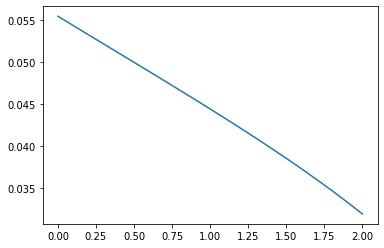

In [147]:
ϕ_pre = ϕ
plt.plot(y_grid_cap, ϕ_pre)

In [148]:
ϕ_pre[-1]

0.031917725705683894

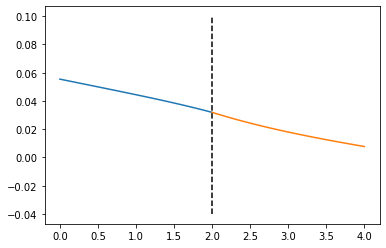

In [149]:
plt.plot(y_grid_cap,ϕ_pre)
plt.plot(y_grid[numy_bar:], (ϕ_low[numy_bar:] + ϕ_high[numy_bar:])/2)
plt.vlines(2, ymin=-.04, ymax=.1, color="black", linestyle="dashed")

# Jump of damage
$$
0 = -\delta \phi + \frac{\partial \phi }{\partial y} \mu_2 e + \delta\eta\log (e) + (\eta-1)(\tau_1 + \tau_2 y) \mu_2 e +\frac{\exp\{\rho( y - \bar y)\}}{1 - \exp\{\rho( y -\bar y)\}} \cdot \left(\sum_{j=2}^{n}\pi_j\tilde \phi(y) - \phi(y)\right) \quad y \in [0, \bar y)
$$
where
$$
    e = -\frac{ \delta\eta}{\frac{\partial \phi }{\partial y} \mu_2 +  (\eta-1)(\tau_1 + \tau_2 y) \mu_2 }
$$

$$
\phi(\bar y) = \sum_{j=2}^{n} \pi_j \phi_j(\bar y)
$$

$$
\text{Jump intensity} = \frac{1}{\sqrt{2\pi}\sigma}\exp\{ - \frac{(y - \bar  y)^2}{2\sigma^2}\}
$$

Try
$$
\sigma = \bar y/10, \quad \bar y/50, \quad \bar y/100
$$

In [150]:
y_dense = np.arange(0,2,1/20000)
def get_intensity(y_grid, σ, γbar=2):
    temp = 1/(np.sqrt(np.pi*2)*σ)*np.exp(-(y_grid - γbar)**2/(2*σ**2))
#     temp *= v_bar - v_new
    return temp

In [167]:
dmg_weight = np.array([0.5, 0.5])
y_grid_cap = np.linspace(0,2,20)
dΛ = γ1 + γ2*y_grid_cap + np.average(γ2p, weights=dmg_weight)*(y_grid_cap - γbar)*(y_grid_cap>γbar)


ϕ_average = np.average([ϕ_low[:numy_bar], ϕ_high[:numy_bar]], axis=0, weights=dmg_weight)
tol = 1e-8


ϕ = - δ*η*y_grid_cap
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
episode = 0

ϕ_dict = dict()
for σ in [γbar/10, γbar/50, γbar/100]:
    ϕ = - δ*η*y_grid_cap
    dy = y_grid_cap[1] - y_grid_cap[0]
    ems = δ*η
    episode = 0
    ϵ = .3
    lhs_error = 1
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
        ems[ems<=0] = 1e-15
        A = -δ*np.ones(y_grid_cap.shape) - get_intensity(y_grid_cap, σ)
        By = μ*ems
        Cyy = np.zeros(y_grid_cap.shape)
        D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems + get_intensity(y_grid_cap, σ)*ϕ_average
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, bd))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    ϕ_dict[σ] = ϕ

episode: 1,	 ode error: 0.06706820753811919,	 ft error: 0.10852575235228065
episode: 2,	 ode error: 0.05539197010043934,	 ft error: 0.017667496037528513
episode: 3,	 ode error: 0.05539197010043647,	 ft error: 0.013820001699277723
episode: 4,	 ode error: 0.055391970100430774,	 ft error: 0.010447709681504717
episode: 5,	 ode error: 0.05539197010040476,	 ft error: 0.008394327721326148
episode: 6,	 ode error: 0.05539197010043234,	 ft error: 0.004476134283868498
episode: 7,	 ode error: 0.05539197010041587,	 ft error: 0.004180058148667425
episode: 8,	 ode error: 0.05539197010041913,	 ft error: 0.008392161649700849
episode: 9,	 ode error: 0.055391970100423744,	 ft error: 0.0033105462226825414
episode: 10,	 ode error: 0.05539197010033463,	 ft error: 0.003061141162281302
episode: 11,	 ode error: 0.05539197010039206,	 ft error: 0.011793037031584715
episode: 12,	 ode error: 0.05539197010043489,	 ft error: 0.0030854781444446004
episode: 13,	 ode error: 0.05539197010042984,	 ft error: 0.01301837841

episode: 189,	 ode error: 0.06778159038614177,	 ft error: 0.005491315610624582
episode: 190,	 ode error: 0.05539197010043551,	 ft error: 0.005457648706308193
episode: 191,	 ode error: 0.06072301603041874,	 ft error: 0.006326926812263388
episode: 192,	 ode error: 0.06729478357963319,	 ft error: 0.008964885911020872
episode: 193,	 ode error: 0.06688523815726344,	 ft error: 0.0070980275887426334
episode: 194,	 ode error: 0.06676626404833888,	 ft error: 0.00614395008005556
episode: 195,	 ode error: 0.06671131469691577,	 ft error: 0.006284088255735834
episode: 196,	 ode error: 0.0670487809258273,	 ft error: 0.00442167995406829
episode: 197,	 ode error: 0.06077222910405361,	 ft error: 0.00489102190097946
episode: 198,	 ode error: 0.06698291976164122,	 ft error: 0.0030853028968650525
episode: 199,	 ode error: 0.066804274636154,	 ft error: 0.010599708474298883
episode: 200,	 ode error: 0.06672848825419411,	 ft error: 0.008712726803878253
episode: 201,	 ode error: 0.06668851664249602,	 ft error

episode: 381,	 ode error: 0.06662249363168986,	 ft error: 0.00017167292968095033
episode: 382,	 ode error: 0.06662249363169537,	 ft error: 0.0001694725039423639
episode: 383,	 ode error: 0.0666224936317007,	 ft error: 0.00016729601451254592
episode: 384,	 ode error: 0.06662249363170583,	 ft error: 0.0001651432361186404
episode: 385,	 ode error: 0.06662249363171076,	 ft error: 0.00016301394171918301
episode: 386,	 ode error: 0.06662249363171548,	 ft error: 0.0001609079031032514
episode: 387,	 ode error: 0.06662249363171995,	 ft error: 0.0001588248914157625
episode: 388,	 ode error: 0.06662249363172422,	 ft error: 0.0001567646776174751
episode: 389,	 ode error: 0.06662249363172823,	 ft error: 0.0001547270328864971
episode: 390,	 ode error: 0.066622493631732,	 ft error: 0.00015271172896909324
episode: 391,	 ode error: 0.06662249363173554,	 ft error: 0.0001507185384846954
episode: 392,	 ode error: 0.06662249363173883,	 ft error: 0.00014874723519064475
episode: 393,	 ode error: 0.0666224936

episode: 580,	 ode error: 0.06662249363138911,	 ft error: 4.8581650635472675e-06
episode: 581,	 ode error: 0.06662249363138875,	 ft error: 4.736514318467999e-06
episode: 582,	 ode error: 0.06662249363138839,	 ft error: 4.617496152381495e-06
episode: 583,	 ode error: 0.06662249363138803,	 ft error: 4.501065405208375e-06
episode: 584,	 ode error: 0.06662249363138768,	 ft error: 4.3871773919059356e-06
episode: 585,	 ode error: 0.06662249363138736,	 ft error: 4.275787904480429e-06
episode: 586,	 ode error: 0.06662249363138703,	 ft error: 4.166853212819732e-06
episode: 587,	 ode error: 0.0666224936313867,	 ft error: 4.060330066381809e-06
episode: 588,	 ode error: 0.06662249363138638,	 ft error: 3.9561756946804305e-06
episode: 589,	 ode error: 0.06662249363138606,	 ft error: 3.854347808765479e-06
episode: 590,	 ode error: 0.06662249363138575,	 ft error: 3.7548046016624057e-06
episode: 591,	 ode error: 0.06662249363138545,	 ft error: 3.6575047493436763e-06
episode: 592,	 ode error: 0.06662249

episode: 10,	 ode error: 0.3224461933158955,	 ft error: 0.001044946867421504
episode: 11,	 ode error: 0.32244619331589547,	 ft error: 0.0010278993971340588
episode: 12,	 ode error: 0.32244619331589547,	 ft error: 0.0010121428892934032
episode: 13,	 ode error: 0.32244619331589525,	 ft error: 0.055287516469903694
episode: 14,	 ode error: 0.3224461933158954,	 ft error: 0.011043456148916822
episode: 15,	 ode error: 0.32244619331589547,	 ft error: 0.0049927801219098265
episode: 16,	 ode error: 0.32244619331589547,	 ft error: 0.004552153522130124
episode: 17,	 ode error: 0.3224461933158955,	 ft error: 0.004150411237053431
episode: 18,	 ode error: 0.3224461933158955,	 ft error: 0.003784125199120392
episode: 19,	 ode error: 0.3224461933158955,	 ft error: 0.0038151933792630616
episode: 20,	 ode error: 0.3224461933158954,	 ft error: 0.011050381745938124
episode: 21,	 ode error: 0.3224461933158954,	 ft error: 0.0028680779535476472
episode: 22,	 ode error: 0.3224461933158955,	 ft error: 0.00261494

episode: 221,	 ode error: 0.3224461933158955,	 ft error: 0.004144523184545767
episode: 222,	 ode error: 0.3224461933158955,	 ft error: 0.004617648604788143
episode: 223,	 ode error: 0.3224461933158955,	 ft error: 0.008146346365731407
episode: 224,	 ode error: 0.3224461933158955,	 ft error: 0.003988460363431682
episode: 225,	 ode error: 0.3224461933158955,	 ft error: 0.0042565749073038865
episode: 226,	 ode error: 0.3224461933158955,	 ft error: 0.008155038673120542
episode: 227,	 ode error: 0.3224461933158955,	 ft error: 0.0038734827097649275
episode: 228,	 ode error: 0.3224461933158955,	 ft error: 0.003984237024437232
episode: 229,	 ode error: 0.32244619331589575,	 ft error: 0.005881444596189887
episode: 230,	 ode error: 0.3224461933158955,	 ft error: 0.00864785485973251
episode: 231,	 ode error: 0.3224461933158955,	 ft error: 0.0036516227158088386
episode: 232,	 ode error: 0.3224461933158955,	 ft error: 0.004227109036052275
episode: 233,	 ode error: 0.3224461933158955,	 ft error: 0.00

episode: 422,	 ode error: 0.33371154348834203,	 ft error: 0.00019583109510001862
episode: 423,	 ode error: 0.33371153437050166,	 ft error: 0.00019419239823246598
episode: 424,	 ode error: 0.3337115255940559,	 ft error: 0.0001925559021326758
episode: 425,	 ode error: 0.33371151714670694,	 ft error: 0.00019092208364462904
episode: 426,	 ode error: 0.3337115090165632,	 ft error: 0.00018929139496177047
episode: 427,	 ode error: 0.33371150119212467,	 ft error: 0.00018766426461068927
episode: 428,	 ode error: 0.3337114936622686,	 ft error: 0.00018604109840975047
episode: 429,	 ode error: 0.333711486416236,	 ft error: 0.0001844222804039721
episode: 430,	 ode error: 0.3337114794436198,	 ft error: 0.00018280817377325695
episode: 431,	 ode error: 0.33371147273435275,	 ft error: 0.00018119912171437233
episode: 432,	 ode error: 0.33371146627869674,	 ft error: 0.00017959544829602991
episode: 433,	 ode error: 0.33371146006723285,	 ft error: 0.00017799745928593255
episode: 434,	 ode error: 0.33371145

episode: 626,	 ode error: 0.3337112991916591,	 ft error: 1.6598027119674175e-05
episode: 627,	 ode error: 0.33371129914268216,	 ft error: 1.6330792340484478e-05
episode: 628,	 ode error: 0.33371129909385955,	 ft error: 1.6067037961591445e-05
episode: 629,	 ode error: 0.33371129904520974,	 ft error: 1.5806732396594914e-05
episode: 630,	 ode error: 0.3337112989967507,	 ft error: 1.5549844175783794e-05
episode: 631,	 ode error: 0.3337112989485001,	 ft error: 1.529634194632109e-05
episode: 632,	 ode error: 0.3337112989004749,	 ft error: 1.5046194472891536e-05
episode: 633,	 ode error: 0.33371129885269163,	 ft error: 1.4799370637678482e-05
episode: 634,	 ode error: 0.33371129880516637,	 ft error: 1.455583944110402e-05
episode: 635,	 ode error: 0.33371129875791455,	 ft error: 1.4315570002106556e-05
episode: 636,	 ode error: 0.33371129871095123,	 ft error: 1.4078531558880947e-05
episode: 637,	 ode error: 0.3337112986642909,	 ft error: 1.3844693469132937e-05
episode: 638,	 ode error: 0.3337112

episode: 838,	 ode error: 0.33371129616845197,	 ft error: 1.5940783924343432e-07
episode: 839,	 ode error: 0.3337112961694372,	 ft error: 1.55127068227993e-07
episode: 840,	 ode error: 0.3337112961704189,	 ft error: 1.5095558715076213e-07
episode: 841,	 ode error: 0.3337112961713966,	 ft error: 1.4689082251477065e-07
episode: 842,	 ode error: 0.3337112961723701,	 ft error: 1.429302543450491e-07
episode: 843,	 ode error: 0.33371129617333906,	 ft error: 1.3907141618862973e-07
episode: 844,	 ode error: 0.333711296174303,	 ft error: 1.353118935186008e-07
episode: 845,	 ode error: 0.33371129617526185,	 ft error: 1.3164932285518e-07
episode: 846,	 ode error: 0.3337112961762152,	 ft error: 1.2808139118747341e-07
episode: 847,	 ode error: 0.3337112961771628,	 ft error: 1.2460583481699317e-07
episode: 848,	 ode error: 0.3337112961781044,	 ft error: 1.212204385481197e-07
episode: 849,	 ode error: 0.3337112961790398,	 ft error: 1.179230346472678e-07
episode: 850,	 ode error: 0.33371129617996864,	

episode: 111,	 ode error: 0.6562639723352192,	 ft error: 0.004168535110770019
episode: 112,	 ode error: 0.6562639723352192,	 ft error: 0.011301423596500802
episode: 113,	 ode error: 0.6562639723352109,	 ft error: 0.011206344108913783
episode: 114,	 ode error: 0.6562639723352192,	 ft error: 0.005255603853151868
episode: 115,	 ode error: 0.6562639723352192,	 ft error: 0.011188536235943129
episode: 116,	 ode error: 0.6562639723352193,	 ft error: 0.002333992854877005
episode: 117,	 ode error: 0.6562639723352193,	 ft error: 0.002885042484755835
episode: 118,	 ode error: 0.6562639723352192,	 ft error: 0.004029195564239554
episode: 119,	 ode error: 0.6562639723352192,	 ft error: 0.01075940386196873
episode: 120,	 ode error: 0.6562639723352235,	 ft error: 0.011214946753687779
episode: 121,	 ode error: 0.6562639723352192,	 ft error: 0.004620252463848526
episode: 122,	 ode error: 0.6562639723352192,	 ft error: 0.011195202442002799
episode: 123,	 ode error: 0.656263972335219,	 ft error: 0.0020500

episode: 324,	 ode error: 0.6677970361518609,	 ft error: 0.00035102959487711327
episode: 325,	 ode error: 0.6677884181649806,	 ft error: 0.00034116217102119395
episode: 326,	 ode error: 0.6677804755971456,	 ft error: 0.0003308051230644279
episode: 327,	 ode error: 0.6677731320457185,	 ft error: 0.00032022343391879354
episode: 328,	 ode error: 0.6677663227016205,	 ft error: 0.00030963915230495154
episode: 329,	 ode error: 0.6677599921711078,	 ft error: 0.00030828240217828373
episode: 330,	 ode error: 0.6677540926436174,	 ft error: 0.00030697072708886036
episode: 331,	 ode error: 0.6677485823054158,	 ft error: 0.0003047899489467173
episode: 332,	 ode error: 0.6677434238880465,	 ft error: 0.0003058317598304827
episode: 333,	 ode error: 0.6677385901364984,	 ft error: 0.00030187864150707977
episode: 334,	 ode error: 0.6677340507991492,	 ft error: 0.00029733650811399526
episode: 335,	 ode error: 0.6677297815727016,	 ft error: 0.0002902555034151507
episode: 336,	 ode error: 0.6677257977292302

episode: 546,	 ode error: 0.6676427654142436,	 ft error: 7.942809355674282e-05
episode: 547,	 ode error: 0.6676427936052702,	 ft error: 7.865472520735921e-05
episode: 548,	 ode error: 0.6676428228938608,	 ft error: 7.788447360004835e-05
episode: 549,	 ode error: 0.6676428533795529,	 ft error: 7.711923617495509e-05
episode: 550,	 ode error: 0.667642909230421,	 ft error: 7.635585749521853e-05
episode: 551,	 ode error: 0.6676429623556951,	 ft error: 7.559588023226908e-05
episode: 552,	 ode error: 0.6676430129065839,	 ft error: 7.4839396132347e-05
episode: 553,	 ode error: 0.6676430610232834,	 ft error: 7.408649253891805e-05
episode: 554,	 ode error: 0.6676431068361406,	 ft error: 7.333725254047205e-05
episode: 555,	 ode error: 0.6676431504667105,	 ft error: 7.259175511843685e-05
episode: 556,	 ode error: 0.6676431920286884,	 ft error: 7.185007529266393e-05
episode: 557,	 ode error: 0.6676432316287026,	 ft error: 7.111228426330551e-05
episode: 558,	 ode error: 0.6676432693669848,	 ft error

episode: 769,	 ode error: 0.6676441546262023,	 ft error: 2.7787483838914717e-06
episode: 770,	 ode error: 0.6676441552367324,	 ft error: 2.722610280859554e-06
episode: 771,	 ode error: 0.6676441558402875,	 ft error: 2.667484176460677e-06
episode: 772,	 ode error: 0.667644156437015,	 ft error: 2.613354665031986e-06
episode: 773,	 ode error: 0.6676441570270604,	 ft error: 2.5602064964574955e-06
episode: 774,	 ode error: 0.6676441576105666,	 ft error: 2.508024576399389e-06
episode: 775,	 ode error: 0.667644158187674,	 ft error: 2.4567939668762584e-06
episode: 776,	 ode error: 0.6676441587585196,	 ft error: 2.4064998869107366e-06
episode: 777,	 ode error: 0.6676441593232374,	 ft error: 2.35712771280705e-06
episode: 778,	 ode error: 0.667644159881958,	 ft error: 2.3086629786830035e-06
episode: 779,	 ode error: 0.6676441604348085,	 ft error: 2.261091376793793e-06
episode: 780,	 ode error: 0.667644160981912,	 ft error: 2.2143987578095623e-06
episode: 781,	 ode error: 0.667644161523388,	 ft er

In [159]:
ϕ_dict

{0.2: array([0.05614794, 0.05501297, 0.05388357, 0.05275844, 0.05163622,
        0.05051544, 0.04939454, 0.04827184, 0.0471455 , 0.04601354,
        0.04487375, 0.04372353, 0.04255952, 0.04137722, 0.04017429,
        0.03895729, 0.0376684 , 0.0363198 , 0.03482149, 0.03191773]),
 0.04: array([0.0558478 , 0.05470261, 0.05356222, 0.05242528, 0.05129034,
        0.05015584, 0.04902014, 0.04788141, 0.04673773, 0.04558695,
        0.04442676, 0.04325459, 0.04206762, 0.04086271, 0.0396365 ,
        0.03838293, 0.03710317, 0.03578715, 0.03443038, 0.03191773]),
 0.02: array([0.05542338, 0.05426267, 0.05310558, 0.05195067, 0.05079637,
        0.04964099, 0.04848272, 0.0473196 , 0.04614947, 0.04497   ,
        0.04377859, 0.04257241, 0.0413483 , 0.04010273, 0.03883177,
        0.03753145, 0.03618452, 0.03481595, 0.03339475, 0.03191773])}

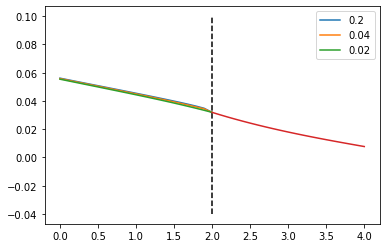

In [162]:
for σ in [γbar/10, γbar/50, γbar/100]:
    plt.plot(y_grid_cap,ϕ_dict[σ], label=σ)
plt.legend()
plt.plot(y_grid[numy_bar:], (ϕ_low[numy_bar:] + ϕ_high[numy_bar:])/2)
plt.vlines(2, ymin=-.04, ymax=.1, color="black", linestyle="dashed")

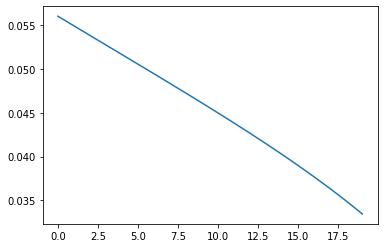

In [164]:
plt.plot(ϕ_average)